## Import libraries

In [1]:
!python -V

Python 3.6.10


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
#from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
#from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
#from sklearn.datasets import make_classification
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from numpy import interp
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pickle
#import keras
from sklearn import preprocessing
import sklearn as sk
print('SKlearn version:',sk.__version__)
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

SKlearn version: 0.22.2.post1
Numpy version: 1.18.1
Pandas version: 1.0.3


In [3]:
import shap
import matplotlib.pylab as pl
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, balanced_accuracy_score, precision_recall_curve, auc, average_precision_score

In [4]:
%matplotlib inline
#plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [5]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import sklearn
from sklearn.metrics import confusion_matrix
from tensorboard.plugins.hparams import api as hp
from tensorflow import feature_column
from tensorflow.keras import layers

In [6]:
from sklearn.model_selection import StratifiedKFold
import numpy

In [7]:
seed = 7
numpy.random.seed(seed)

In [8]:
seed

7

## Import dataset

In [9]:
df=pd.read_csv('dengue data-Final.csv')
df=df.drop(['RNA'],  axis=1)

In [10]:
train_df, test_df = train_test_split(df, test_size=.1, 
                                         stratify=df.Severity, random_state=seed)

In [11]:
train_df.head()

Severity  sex  age  NS1  IgM  IgG
123         0    1   20    1    1    0
696         0    0   46    1    0    1
153         0    0   36    0    1    0
157         0    1   49    1    0    0
560         1    1   69    1    0    0

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718 entries, 123 to 21
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Severity  718 non-null    int64
 1   sex       718 non-null    int64
 2   age       718 non-null    int64
 3   NS1       718 non-null    int64
 4   IgM       718 non-null    int64
 5   IgG       718 non-null    int64
dtypes: int64(6)
memory usage: 39.3 KB


## Data preprocessing piprlines
Prepare the data to a format that can be fit into scikit learn algorithms

**Transform data in a pipeline** 

 
For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

In [13]:
def PreprocessData (raw_df):
    ndarray=raw_df.values
    Label=ndarray[:,0]
    Features=raw_df.drop(['Severity'], axis=1)
    Features['age']=Features['age']/100
    scaleFeatures=Features.values
        
    return scaleFeatures, Label

In [14]:
train_Features, train_Label=PreprocessData(train_df)
test_Features, test_Label=PreprocessData(test_df)

In [15]:
X, Y=PreprocessData(df)

## Fitting classifiers

In [16]:
train_df['Severity'].value_counts()

0    594
1    124
Name: Severity, dtype: int64

This is an unbalanced dataset(i.e., the number of positive and negative cases are not the same), and we'll use AUCROC as our metric to optimise the model performance.

**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [17]:
def plot_learning_curves(model, X, y):

    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Average_precision")
    plt.title('{} learning curve'.format(model.__class__.__name__))

In [18]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

In [19]:
def plot_precision_recall_curve(fpr, tpr, auprc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='AUPRC: {}'.format(auprc))
    plt.plot([0, 1], [0.1, 0.1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - PR Curve'.format(title))

### Logistic Regression
Our first model is logistic regression

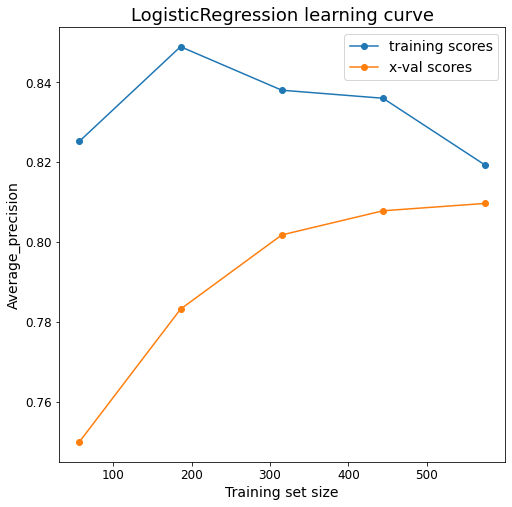

In [20]:
lr_clf = LogisticRegression(n_jobs = -1, 
                           class_weight='balanced'
                           )
plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

Let's see if we can squeeze some more performance out by optimising C and class_weight.

In [21]:
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
   'class_weight': ['balanced', None]
    }
lr_clf = LogisticRegression(random_state=seed)
#scorings ={'precision', 'recall', 'roc_auc'}
#scoring = {make_scorer(auc)}
#make_scorer(accuracy_score)
grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=10, scoring='roc_auc', n_jobs=-1)
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=7, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'class_weight': ['balanced', None]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

In [22]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores                                   Params
0       0.820253      0.820981          {'C': 10, 'class_weight': None}
1       0.819726      0.821114         {'C': 100, 'class_weight': None}
2       0.819584      0.821141        {'C': 1000, 'class_weight': None}
3       0.818589      0.819427     {'C': 1, 'class_weight': 'balanced'}
4       0.817140      0.818423           {'C': 1, 'class_weight': None}
5       0.816443      0.820355   {'C': 100, 'class_weight': 'balanced'}
6       0.816299      0.820277    {'C': 10, 'class_weight': 'balanced'}
7       0.816182      0.820439  {'C': 1000, 'class_weight': 'balanced'}
8       0.804289      0.805559   {'C': 0.1, 'class_weight': 'balanced'}
9       0.796725      0.797682         {'C': 0.1, 'class_weight': None}
10      0.784856      0.786056  {'C': 0.01, 'class_weight': 'balanced'}
11      0.779189      0.780962        {'C': 0.01, 'class_weight': None}

Looks like C=1000 is our best value.

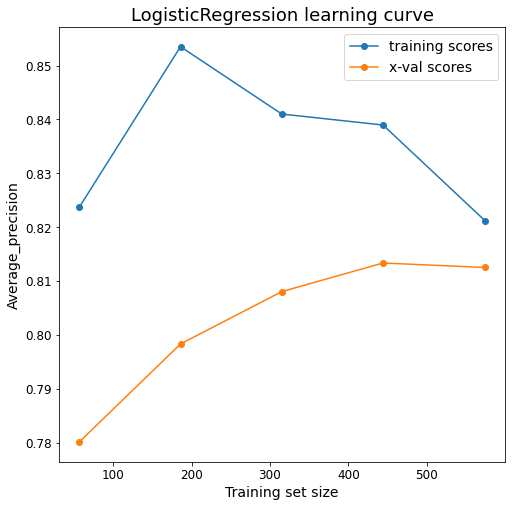

In [23]:
lr_clf = grid_search.best_estimator_

plot_learning_curves(lr_clf, train_Features, train_df['Severity'])

In [24]:
with open('./finalmodel/lr_clf_final_round.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

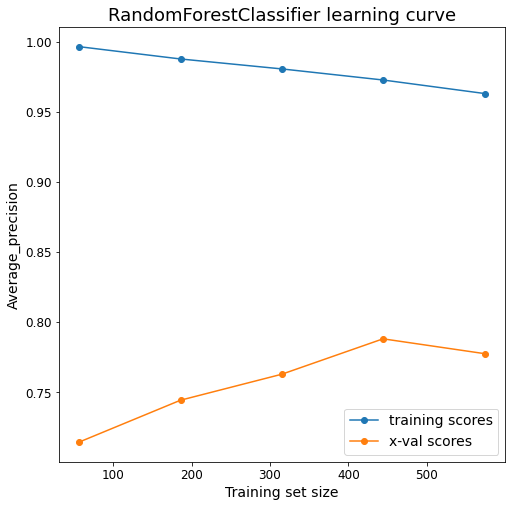

In [25]:
rf_clf = RandomForestClassifier(random_state=seed, 
                              class_weight='balanced'
                               )
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

This is a typical overfitting curve. The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [26]:
param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
        'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
        'class_weight': ['balanced', None]
    }
#rf_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=10, scoring='roc_auc', random_state=seed, n_jobs=-1)
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
        

In [27]:
cv_rlt = rnd_search.cv_results_
rf_clf = rnd_search.best_estimator_

pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.821737      0.866285   
1       0.821710      0.867745   
2       0.819901      0.864255   
3       0.818506      0.882213   
4       0.815691      0.857211   
..           ...           ...   
95      0.764839      0.784297   
96      0.764021      0.787555   
97      0.760157      0.778752   
98      0.673345      0.670751   
99      0.646166      0.662059   

                                               Params  
0   {'class_weight': None, 'max_depth': 94, 'max_f...  
1   {'class_weight': None, 'max_depth': 71, 'max_f...  
2   {'class_weight': None, 'max_depth': 44, 'max_f...  
3   {'class_weight': None, 'max_depth': 57, 'max_f...  
4   {'class_weight': 'balanced', 'max_depth': 45, ...  
..                                                ...  
95  {'class_weight': None, 'max_depth': 70, 'max_f...  
96  {'class_weight': None, 'max_depth': 30, 'max_f...  
97  {'class_weight': None, 'max_depth': 94, 'max_f...  
98  {'class_weight': None, 'max_depth': 35, 'max_f...  
99  {'class_weight': None, 'max_depth': 74, 'max_f...  

[100 rows x 3 columns]

As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

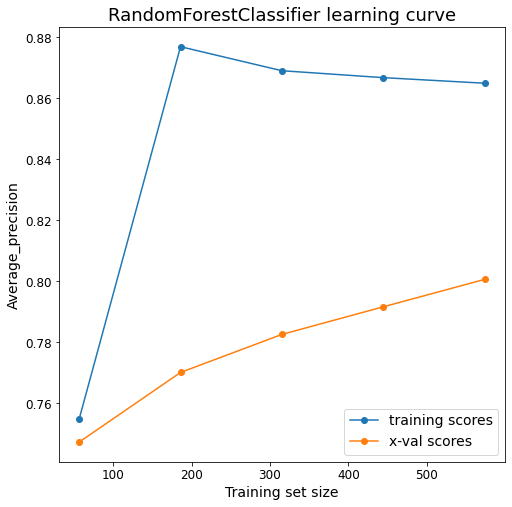

In [28]:
plot_learning_curves(rf_clf, train_Features, train_df['Severity'])

In [29]:
#rf_clf = rnd_search.best_estimator_
rf_clf.fit(train_Features, train_df['Severity'], )
with open('./finalmodel/rf_clf_final_round.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

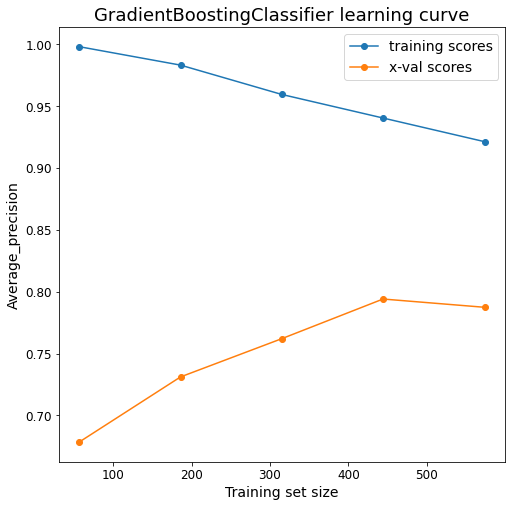

In [30]:
plot_learning_curves(GradientBoostingClassifier(random_state=seed), train_Features, train_df['Severity'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [31]:
param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100)
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=seed), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=10, scoring='roc_auc', random_state=42, n_jobs=-1)
# this will take a long time
rnd_search.fit(train_Features, train_df['Severity'])

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                   

In [32]:
cv_rlt = rnd_search.cv_results_
gbm_clf = rnd_search.best_estimator_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

X-val scores  Train scores  \
0       0.816167      0.891629   
1       0.815611      0.884633   
2       0.815498      0.855950   
3       0.815055      0.857305   
4       0.815005      0.864907   
..           ...           ...   
95      0.771032      0.961418   
96      0.769239      0.968532   
97      0.768825      0.968672   
98      0.768001      0.964860   
99      0.766942      0.967890   

                                               Params  
0   {'max_depth': 12, 'min_samples_leaf': 63, 'min...  
1   {'max_depth': 17, 'min_samples_leaf': 63, 'min...  
2   {'max_depth': 25, 'min_samples_leaf': 97, 'min...  
3   {'max_depth': 11, 'min_samples_leaf': 91, 'min...  
4   {'max_depth': 18, 'min_samples_leaf': 98, 'min...  
..                                                ...  
95  {'max_depth': 15, 'min_samples_leaf': 4, 'min_...  
96  {'max_depth': 35, 'min_samples_leaf': 2, 'min_...  
97  {'max_depth': 42, 'min_samples_leaf': 2, 'min_...  
98  {'max_depth': 44, 'min_samples_leaf': 5, 'min_...  
99  {'max_depth': 42, 'min_samples_leaf': 5, 'min_...  

[100 rows x 3 columns]

We'll save the best model, retrain it on the whole dataset and save the model

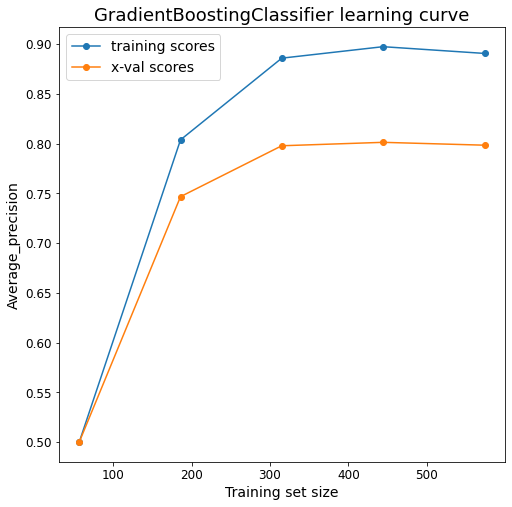

In [33]:
plot_learning_curves(gbm_clf, train_Features, train_df['Severity'])

In [34]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(train_Features, train_df['Severity'])
with open('./finalmodel/gbm_clf_final_round.pkl', 'wb') as f:
    pickle.dump(gbm_clf, f)

The learning curve of the best Gradient Boosting model suggests that the performance of the model might continue to increase with more traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

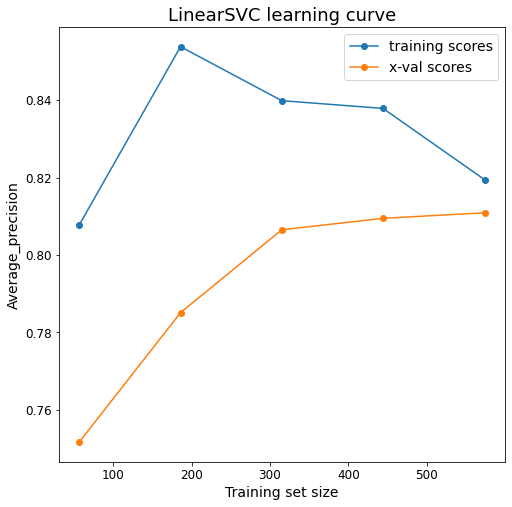

In [35]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=seed, class_weight= 'balanced'), train_Features, train_df['Severity'] )

Try Polynomial kernel

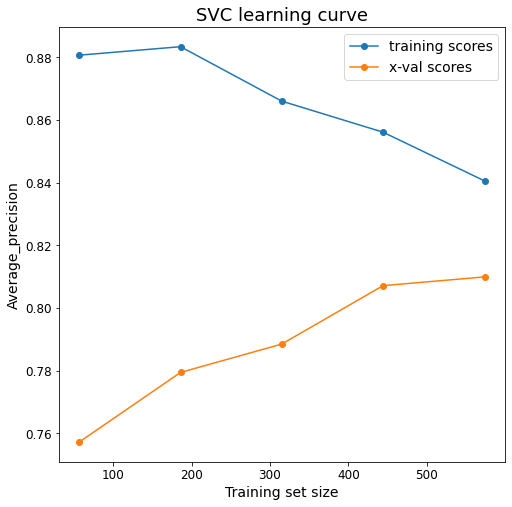

In [36]:
plot_learning_curves(SVC(kernel='poly', random_state=seed,class_weight= 'balanced'), train_Features, train_df['Severity'])

Try Gaussian RBF kernel

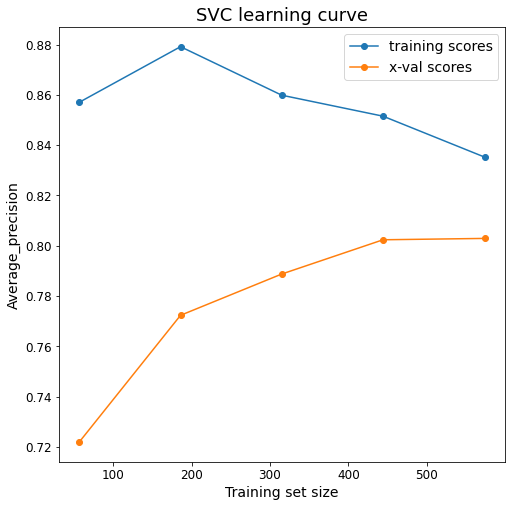

In [37]:
plot_learning_curves(SVC(random_state=seed, class_weight= 'balanced'), train_Features, train_df['Severity'])

The learning curve of the Linear SVC shows sign of underfitting, and provide evidence that the data set is not linearly seperatable.  

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [38]:
rbf_gamma = [1/len(train_df.columns) * x for x in range(1, 15, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 3, 9],  'class_weight': ['balanced', None]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 3, 9],  'class_weight': ['balanced', None]},
    
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=seed), param_grid, cv=10,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(train_Features, train_df['Severity'])

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=7, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': [1, 3, 9], 'class_weight': ['balanced', None],
                          'degree': [3, 9, 15], 'kernel': ['poly']},
                         {'C': [1, 3, 9], 'class_weight': ['balanced', None],
                          'gamma': [0.16666666666666666, 1.0,
                                    1.8333333333333333]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [38]:
cv_rlt = grid_search.cv_results_
svc_clf = grid_search.best_estimator_

In [39]:
cv_rlt

{'mean_fit_time': array([0.00488462, 0.00567386, 0.00890281, 0.00825357, 0.00817485,
        0.0073561 , 0.00779226, 0.00982955, 0.00753152, 0.00817921,
        0.00840943, 0.00845931]),
 'std_fit_time': array([0.00041562, 0.00110142, 0.00177367, 0.00271723, 0.00215292,
        0.00102426, 0.00132325, 0.00219709, 0.0011989 , 0.00156275,
        0.00190412, 0.00182234]),
 'mean_score_time': array([0.0016691 , 0.00194349, 0.00210755, 0.00173836, 0.00175326,
        0.00168386, 0.0017117 , 0.00192821, 0.00165174, 0.00182793,
        0.00186636, 0.00161459]),
 'std_score_time': array([0.0001928 , 0.00019527, 0.00045936, 0.00041733, 0.00036384,
        0.00038271, 0.00034492, 0.00051332, 0.00033272, 0.00047527,
        0.000464  , 0.00029979]),
 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10, 100, 100, 1000,
                    1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_va

In [41]:
svc_clf.fit(train_Features, train_df['Severity'])
with open('./finalmodel/svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

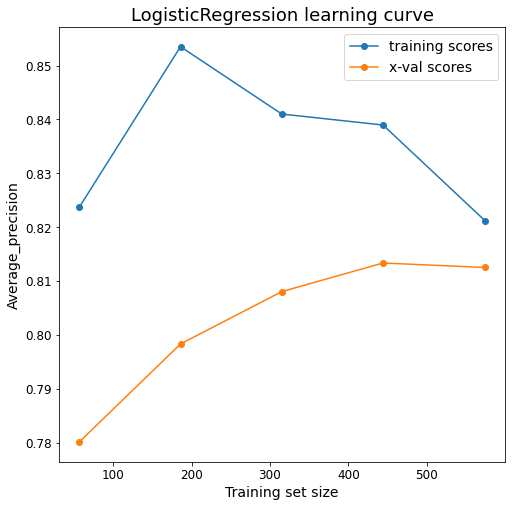

In [40]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, train_Features, train_df['Severity']) 

## Compute and compare test metrics

**Compute test accuracy score**

### _Logistic Regression model_

In [20]:
# Import model and retrain
with open('./finalmodel/lr_clf_final_round.pkl', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(train_Features, train_df['Severity'])

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy scores

In [21]:
accu_lr = accuracy_score(test_df['Severity'], lr_clf.predict(test_Features))
accu_lr

0.875

Balance accuracy score

In [22]:
balance_accu_lr=balanced_accuracy_score(test_df['Severity'], lr_clf.predict(test_Features))
balance_accu_lr

0.6428571428571428

In [23]:
pd.crosstab(test_df['Severity'], lr_clf.predict(test_Features))

col_0      0  1
Severity       
0         66  0
1         10  4

ROC and AUC

In [24]:
pred_proba_lr = lr_clf.predict_proba(test_Features)
fpr_lr, tpr_lr, _ = roc_curve(test_df['Severity'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(test_df['Severity'], pred_proba_lr[:, 1])

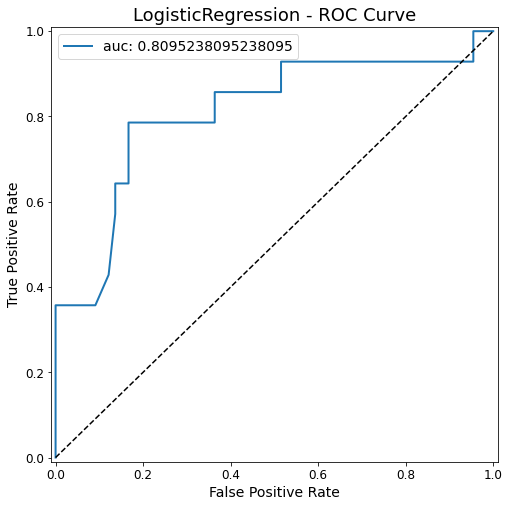

In [25]:
plot_roc_curve(fpr_lr, tpr_lr, auc_lr, lr_clf)

auc_lr_prc=0.6104 ap_lr=0.6187


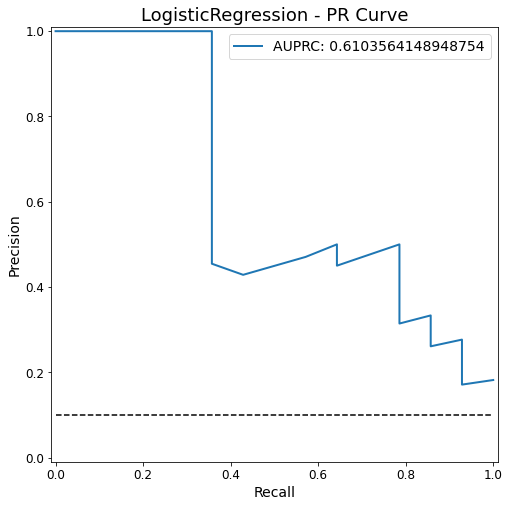

In [26]:
# keep probabilities for the positive outcome only
pred_proba_lr = pred_proba_lr[:, 1]
# predict class values
yhat = lr_clf.predict(test_Features)
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(test_Label, pred_proba_lr)
# calculate precision-recall AUC
auc_lr_pr=auc(recall_lr, precision_lr)
# calculate average precision score
ap_lr_pr = average_precision_score(test_Label, pred_proba_lr)
print('auc_lr_prc=%.4f ap_lr=%.4f' % (auc_lr_pr, ap_lr_pr))

plot_precision_recall_curve(recall_lr, precision_lr, auc_lr_pr, lr_clf)

### _Random forests model_

In [27]:
# Import model and retrain
with open('./finalmodel/rf_clf_final_round.pkl', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(train_Features, train_df['Severity'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=94, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=13, min_samples_split=13,
                       min_weight_fraction_leaf=0.0, n_estimators=23,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

Accuracy scores

In [28]:
accu_rf = accuracy_score(test_df['Severity'], rf_clf.predict(test_Features))
accu_rf

0.825

Balance accuracy scores

In [29]:
balance_accu_rf=balanced_accuracy_score(test_df['Severity'], rf_clf.predict(test_Features))
balance_accu_rf

0.5281385281385281

In [30]:
pd.crosstab(test_df['Severity'], rf_clf.predict(test_Features))

col_0      0  1
Severity       
0         65  1
1         13  1

ROC and AUC

In [31]:
pred_proba_rf = rf_clf.predict_proba(test_Features)
fpr_rf, tpr_rf, _ = roc_curve(test_df['Severity'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(test_df['Severity'], pred_proba_rf[:, 1])

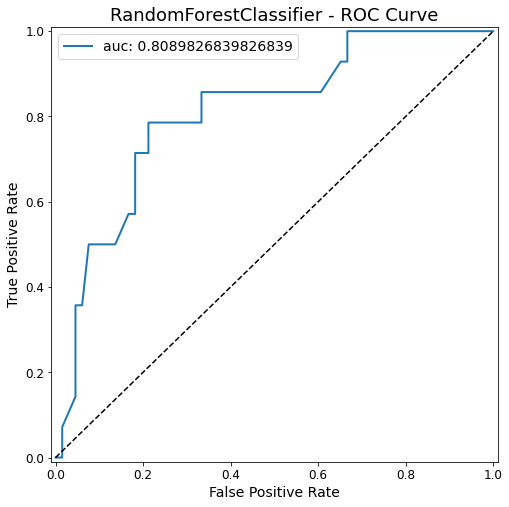

In [32]:
plot_roc_curve(fpr_rf, tpr_rf, auc_rf, rf_clf)

auc_rf=0.4246 ap_rf=0.4543


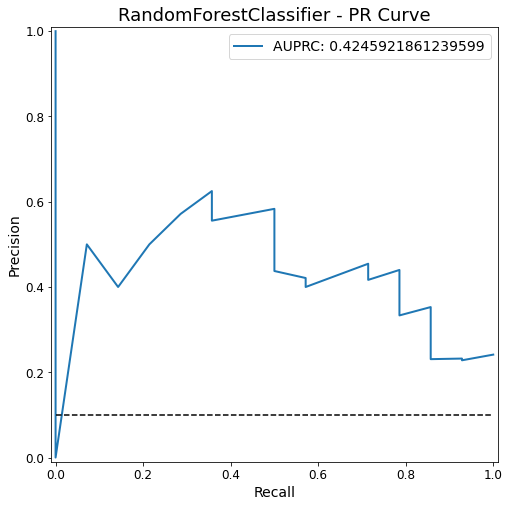

In [33]:
# keep probabilities for the positive outcome only
pred_proba_rf = pred_proba_rf[:, 1]
# predict class values
yhat = rf_clf.predict(test_Features)
# calculate precision-recall curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(test_Label, pred_proba_rf)
# calculate precision-recall AUC
auc_rf_pr=auc(recall_rf, precision_rf)
# calculate average precision score
ap_rf_pr = average_precision_score(test_Label, pred_proba_rf)
print('auc_rf=%.4f ap_rf=%.4f' % (auc_rf_pr, ap_rf_pr))

plot_precision_recall_curve(recall_rf, precision_rf, auc_rf_pr, rf_clf)

### _Gradient boosting machine model_

In [34]:
# Import model and retrain
with open('finalmodel/gbm_clf_final_round.pkl', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(train_Features, train_df['Severity'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=12,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=63, min_samples_split=15,
                           min_weight_fraction_leaf=0.0, n_estimators=174,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=7, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy scores

In [35]:
accu_gbm = accuracy_score(test_df['Severity'], gbm_clf.predict(test_Features))
accu_gbm

0.8375

Balance accuracy scores

In [36]:
balance_accu_gbm=balanced_accuracy_score(test_df['Severity'], gbm_clf.predict(test_Features))
balance_accu_gbm

0.6201298701298701

In [37]:
pd.crosstab(test_df['Severity'], gbm_clf.predict(test_Features))

col_0      0  1
Severity       
0         63  3
1         10  4

ROC and AUC

In [38]:
pred_proba_gbm = gbm_clf.predict_proba(test_Features)
fpr_gbm, tpr_gbm, _ = roc_curve(test_df['Severity'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(test_df['Severity'], pred_proba_gbm[:, 1])

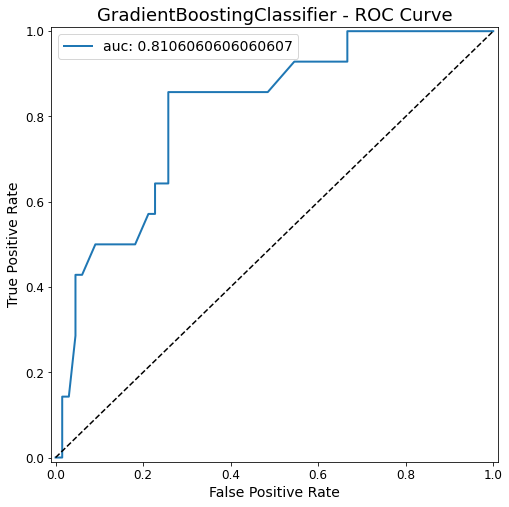

In [39]:
plot_roc_curve(fpr_gbm, tpr_gbm, auc_gbm, gbm_clf)

auc_gbm=0.4347 ap_gbm=0.4733


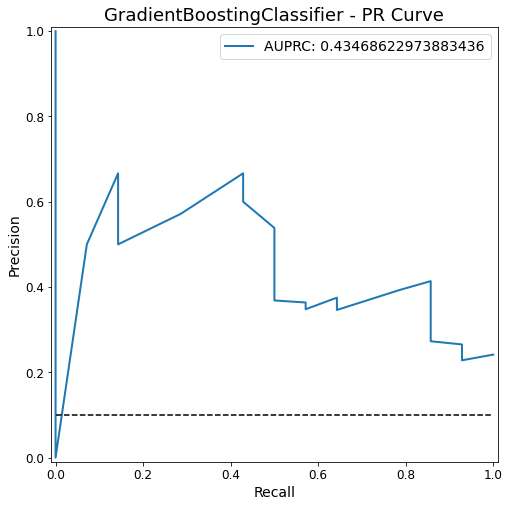

In [40]:
# predict probabilities
pred_proba_gbm = gbm_clf.predict_proba(test_Features)
# keep probabilities for the positive outcome only
pred_proba_gbm = pred_proba_gbm[:, 1]
# predict class values
yhat = gbm_clf.predict(test_Features)
# calculate precision-recall curve
precision_gbm, recall_gbm, thresholds_gbm = precision_recall_curve(test_Label, pred_proba_gbm)

# calculate precision-recall AUC
auc_gbm_pr=auc(recall_gbm, precision_gbm)
# calculate average precision score
ap_gbm_pr = average_precision_score(test_Label, pred_proba_gbm)
print('auc_gbm=%.4f ap_gbm=%.4f' % (auc_gbm_pr, ap_gbm_pr))

plot_precision_recall_curve(recall_gbm, precision_gbm, auc_gbm_pr, gbm_clf)

### _Support vector machine model_

In [41]:
# Import model and retrain
with open('./finalmodel/svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(train_Features, train_df['Severity'])

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=True, random_state=7, shrinking=True, tol=0.001,
    verbose=False)

Accuracy scores

In [42]:
accu_svc = accuracy_score(test_df['Severity'], svc_clf.predict(test_Features))
accu_svc

0.7

Balance accuracy scores

In [43]:
balance_accu_svc=balanced_accuracy_score(test_df['Severity'], svc_clf.predict(test_Features))
balance_accu_svc

0.7619047619047619

In [44]:
pd.crosstab(test_df['Severity'], svc_clf.predict(test_Features))

col_0      0   1
Severity        
0         44  22
1          2  12

ROC and AUC

In [45]:
pred_proba_svc = svc_clf.predict_proba(test_Features)
fpr_svc, tpr_svc, _ = roc_curve(test_df['Severity'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(test_df['Severity'], pred_proba_svc[:, 1])

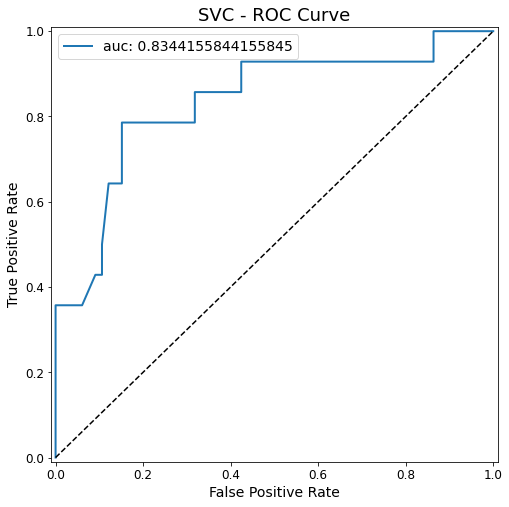

In [46]:
plot_roc_curve(fpr_svc, tpr_svc, auc_svc, svc_clf)

auc_svc=0.6349 ap_svc=0.6417


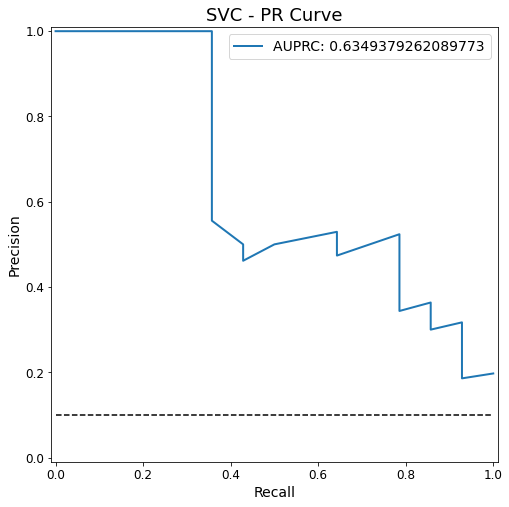

In [47]:
# keep probabilities for the positive outcome only
pred_proba_svc = pred_proba_svc[:, 1]
# predict class values
yhat = svc_clf.predict(test_Features)
# calculate precision-recall curve
precision_svc, recall_svc, thresholds = precision_recall_curve(test_Label, pred_proba_svc)
# calculate precision-recall AUC
auc_svc_pr=auc(recall_svc, precision_svc)
# calculate average precision score
ap_svc_pr = average_precision_score(test_Label, pred_proba_svc)
print('auc_svc=%.4f ap_svc=%.4f' % (auc_svc_pr, ap_svc_pr))

plot_precision_recall_curve(recall_svc, precision_svc, auc_svc_pr, svc_clf)

### Deep Learning

# Hyperparameters of deep learning

In [69]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [22]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [72]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    #tf.config.experimental.set_memory_growth(gpus[0], True)
    #tf.config.gpu.set_per_process_memory_fraction(0.75)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [73]:
unique, counts = np.unique(train_Label, return_counts=True)

In [74]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.60
Weight for class 1: 2.90


In [75]:
HP_NUM_UNITS1 = hp.HParam('num_units 1', hp.Discrete([50, 100, 150, 200])) 
HP_NUM_UNITS2 = hp.HParam('num_units 2', hp.Discrete([50, 100, 150, 200]))
HP_NUM_UNITS3 = hp.HParam('num_units 3', hp.Discrete([50, 100, 150, 200]))
HP_DROPOUT1 = hp.HParam('dropout 1', hp.Discrete([0.1, 0.3]))
HP_DROPOUT2= hp.HParam('dropout 2', hp.Discrete([0.1, 0.3]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam']))

METRIC_ACCURACY = 'ROC_AUC'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS1,HP_NUM_UNITS2, HP_NUM_UNITS3,HP_DROPOUT1, HP_DROPOUT2, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='ROC_AUC')],
  )


train_noval_df, val_df = train_test_split(train_df, test_size=.1, 
                                         stratify=train_df.Severity, random_state=seed)
train_noval_Features, train_noval_Label=PreprocessData(train_noval_df)
val_Features, val_Label=PreprocessData(val_df)

In [76]:
def train_test_model(hparams, X, Y):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    accuracy_kfold=[]
    for train, test in kfold.split(X, Y):
        dataset = tf.data.Dataset.from_tensor_slices((X[train], Y[train])) # Creates a dataset object 
        #dataset = dataset.map(preprocessing, num_parallel_calls=64) # parallel preprocessing
        dataset = dataset.batch(20)
        dataset = dataset.prefetch(None) # Will automatically prefetch batches

        model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT2]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS3], activation=tf.nn.relu),
        tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
            ])
        model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss='binary_crossentropy',
         metrics=[tf.keras.metrics.AUC()])

        model.fit(X[train], Y[train], class_weight=class_weight,
          epochs=300, batch_size=20, verbose=0 ) 
        _, accuracy = model.evaluate(X[test], Y[test])
        accuracy_kfold.append(accuracy)
        
    return numpy.mean(accuracy_kfold)

In [77]:
def run(run_dir, hparams, X, Y):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams, X, Y)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [30]:
session_num = 0
for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for dropout_rate1 in HP_DROPOUT1.domain.values:
                for dropout_rate2 in HP_DROPOUT2.domain.values:
                     for optimizer in HP_OPTIMIZER.domain.values:
          
                            hparams = {
              HP_NUM_UNITS1: num_units1,
              HP_NUM_UNITS2: num_units2,
              HP_NUM_UNITS3: num_units3,
              HP_DROPOUT1: dropout_rate1,
              HP_DROPOUT2: dropout_rate2,
              #HP_L2: l2,
              HP_OPTIMIZER: optimizer
              
          }
                            run_name = "run-%d" % session_num
                            #print('--- Starting trial: %s' % run_name)
                            #print({h.name: hparams[h] for h in hparams})
                            run('logs/hparam_tuning/' + run_name, hparams, X, Y)
                            session_num += 1

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

79/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

80/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [78]:
%tensorboard --logdir logs20200622/hparam_tuning --reload_multifile=true

Reusing TensorBoard on port 6007 (pid 24076), started 1 day, 1:27:33 ago. (Use '!kill 24076' to kill it.)

Hyperparameter results can be seen in " http://localhost:6006/ ".

# NL model evaluation

In [48]:
#mpl.rcParams['figure.figsize'] = (12, 10)
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

file = tf.keras.utils


def make_model(
    #metrics = METRICS,output_bias=None
      ):
  #if output_bias is not None:
  #  output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(50, activation='relu', input_shape=(train_Features.shape[-1],)),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dropout(0.3),
      keras.layers.Dense(150, activation='relu'),
      keras.layers.Dense(1, activation='sigmoid')])
      
      
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.AUC()]
  )

  return model

model = make_model()
model.summary()

initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
unique, counts = np.unique(train_Label, return_counts=True)
weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}


print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_model.fit(
    train_Features,
    train_Label,
    batch_size=20,
    epochs=300,
    validation_data=(test_Features, test_Label),
    # The class weights go here
    class_weight=class_weight) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                300       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
____________________________________________________

718/718 [==============================] - 0s 408us/sample - loss: 0.5048 - auc_1: 0.8282 - val_loss: 0.5150 - val_auc_1: 0.8382
Epoch 51/300
718/718 [==============================] - 0s 395us/sample - loss: 0.4891 - auc_1: 0.8408 - val_loss: 0.5006 - val_auc_1: 0.8523
Epoch 52/300
718/718 [==============================] - 0s 398us/sample - loss: 0.5083 - auc_1: 0.8246 - val_loss: 0.5254 - val_auc_1: 0.8469
Epoch 53/300
718/718 [==============================] - 0s 393us/sample - loss: 0.5065 - auc_1: 0.8280 - val_loss: 0.4966 - val_auc_1: 0.8512
Epoch 54/300
718/718 [==============================] - 0s 417us/sample - loss: 0.5130 - auc_1: 0.8228 - val_loss: 0.5014 - val_auc_1: 0.8479
Epoch 55/300
718/718 [==============================] - 0s 383us/sample - loss: 0.4869 - auc_1: 0.8423 - val_loss: 0.5154 - val_auc_1: 0.8339
Epoch 56/300
718/718 [==============================] - 0s 390us/sample - loss: 0.5056 - auc_1: 0.8280 - val_loss: 0.5141 - val_auc_1: 0.8247
Epoch 57/300
718/71

Epoch 108/300
718/718 [==============================] - 0s 416us/sample - loss: 0.4767 - auc_1: 0.8494 - val_loss: 0.5037 - val_auc_1: 0.8306
Epoch 109/300
718/718 [==============================] - 0s 420us/sample - loss: 0.4952 - auc_1: 0.8323 - val_loss: 0.4994 - val_auc_1: 0.8479
Epoch 110/300
718/718 [==============================] - 0s 398us/sample - loss: 0.4949 - auc_1: 0.8380 - val_loss: 0.4913 - val_auc_1: 0.8404
Epoch 111/300
718/718 [==============================] - 0s 400us/sample - loss: 0.4849 - auc_1: 0.8415 - val_loss: 0.4963 - val_auc_1: 0.8463
Epoch 112/300
718/718 [==============================] - 0s 395us/sample - loss: 0.4829 - auc_1: 0.8410 - val_loss: 0.5034 - val_auc_1: 0.8458
Epoch 113/300
718/718 [==============================] - 0s 405us/sample - loss: 0.4891 - auc_1: 0.8378 - val_loss: 0.4913 - val_auc_1: 0.8425
Epoch 114/300
718/718 [==============================] - 0s 416us/sample - loss: 0.4989 - auc_1: 0.8348 - val_loss: 0.4986 - val_auc_1: 0.8398

718/718 [==============================] - 0s 414us/sample - loss: 0.4723 - auc_1: 0.8472 - val_loss: 0.4785 - val_auc_1: 0.8469
Epoch 166/300
718/718 [==============================] - 0s 416us/sample - loss: 0.4708 - auc_1: 0.8505 - val_loss: 0.4797 - val_auc_1: 0.8555
Epoch 167/300
718/718 [==============================] - 0s 426us/sample - loss: 0.4621 - auc_1: 0.8538 - val_loss: 0.4763 - val_auc_1: 0.8512
Epoch 168/300
718/718 [==============================] - 0s 400us/sample - loss: 0.4712 - auc_1: 0.8523 - val_loss: 0.4686 - val_auc_1: 0.8690
Epoch 169/300
718/718 [==============================] - 0s 407us/sample - loss: 0.4662 - auc_1: 0.8545 - val_loss: 0.4701 - val_auc_1: 0.8555
Epoch 170/300
718/718 [==============================] - 0s 410us/sample - loss: 0.4817 - auc_1: 0.8416 - val_loss: 0.4942 - val_auc_1: 0.8431
Epoch 171/300
718/718 [==============================] - 0s 403us/sample - loss: 0.4668 - auc_1: 0.8527 - val_loss: 0.4799 - val_auc_1: 0.8555
Epoch 172/300

718/718 [==============================] - 0s 469us/sample - loss: 0.4468 - auc_1: 0.8613 - val_loss: 0.4651 - val_auc_1: 0.8544
Epoch 223/300
718/718 [==============================] - 0s 432us/sample - loss: 0.4569 - auc_1: 0.8554 - val_loss: 0.4664 - val_auc_1: 0.8571
Epoch 224/300
718/718 [==============================] - 0s 416us/sample - loss: 0.4675 - auc_1: 0.8533 - val_loss: 0.4790 - val_auc_1: 0.8517
Epoch 225/300
718/718 [==============================] - 0s 415us/sample - loss: 0.4562 - auc_1: 0.8553 - val_loss: 0.4706 - val_auc_1: 0.8528
Epoch 226/300
718/718 [==============================] - 0s 411us/sample - loss: 0.4652 - auc_1: 0.8526 - val_loss: 0.4670 - val_auc_1: 0.8669
Epoch 227/300
718/718 [==============================] - 0s 416us/sample - loss: 0.4463 - auc_1: 0.8656 - val_loss: 0.4890 - val_auc_1: 0.8458
Epoch 228/300
718/718 [==============================] - 0s 408us/sample - loss: 0.4577 - auc_1: 0.8573 - val_loss: 0.4777 - val_auc_1: 0.8512
Epoch 229/300

718/718 [==============================] - 0s 390us/sample - loss: 0.4499 - auc_1: 0.8611 - val_loss: 0.4670 - val_auc_1: 0.8571
Epoch 280/300
718/718 [==============================] - 0s 388us/sample - loss: 0.4473 - auc_1: 0.8643 - val_loss: 0.4764 - val_auc_1: 0.8539
Epoch 281/300
718/718 [==============================] - 0s 389us/sample - loss: 0.4365 - auc_1: 0.8691 - val_loss: 0.4638 - val_auc_1: 0.8561
Epoch 282/300
718/718 [==============================] - 0s 403us/sample - loss: 0.4518 - auc_1: 0.8586 - val_loss: 0.4835 - val_auc_1: 0.8474
Epoch 283/300
718/718 [==============================] - 0s 402us/sample - loss: 0.4586 - auc_1: 0.8549 - val_loss: 0.4727 - val_auc_1: 0.8479
Epoch 284/300
718/718 [==============================] - 0s 385us/sample - loss: 0.4442 - auc_1: 0.8665 - val_loss: 0.4731 - val_auc_1: 0.8604
Epoch 285/300
718/718 [==============================] - 0s 388us/sample - loss: 0.4703 - auc_1: 0.8444 - val_loss: 0.4879 - val_auc_1: 0.8452
Epoch 286/300

In [49]:
weighted_model.save('./finalmodel/ANN_model.h5')

col_0      0   1
Severity        
0         47  19
1          3  11

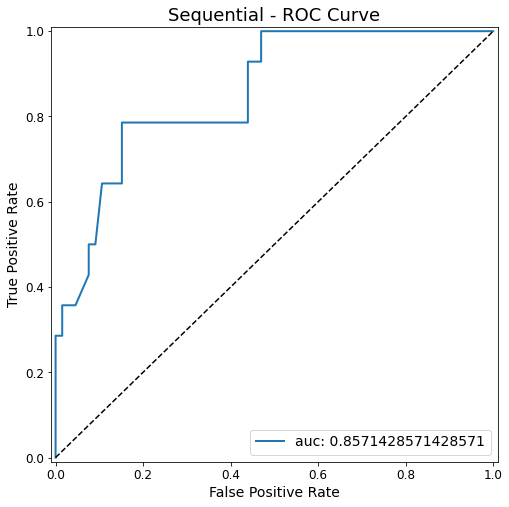

In [50]:
test_probability=weighted_model.predict(test_Features)

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr_NL, tpr_NL, _ = roc_curve(test_df['Severity'], test_probability)
auc_NL = roc_auc_score(test_df['Severity'], test_probability)
plot_roc_curve(fpr_NL, tpr_NL, auc_NL, model)

test_class=weighted_model.predict_classes(test_Features)

pd.crosstab(test_df['Severity'], test_class[:,0])

#test_probability=weighted_model.predict(test_Features)

In [51]:
#scores=weighted_model.evaluate(test_Features, test_Label, verbose=0)

In [52]:
accu_NL=accuracy_score(test_Label, test_class)
accu_NL

0.725

In [53]:
balance_accu_NL=balanced_accuracy_score(test_Label, test_class)
balance_accu_NL

0.748917748917749

test_reshape=np.reshape(test_probability, test_probability.shape[0])
pd.crosstab(test_Label, test_reshape,
           rownames=['lable'], colnames=['prediction'])

auc_NL_pr=0.6395 ap=0.6463


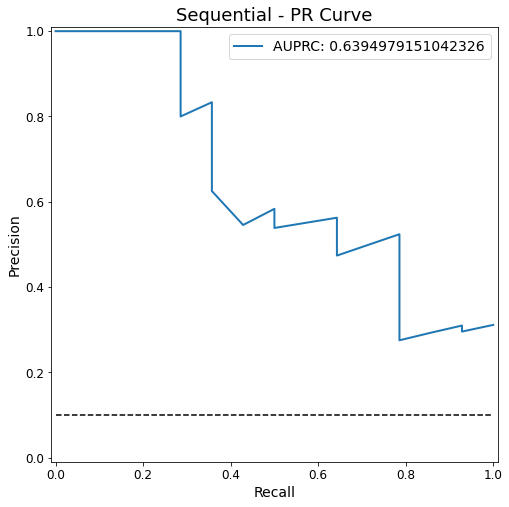

In [54]:
# predict probabilities
#test_probability=weighted_model.predict(test_Features)
pred_proba_NL = np.reshape(test_probability, test_probability.shape[0])
# keep probabilities for the positive outcome only
#pred_proba_NL = pred_proba_NL[:, 1]
# predict class values
yhat = test_class
# calculate precision-recall curve
precision_NL, recall_NL, thresholds = precision_recall_curve(test_Label, pred_proba_NL)
# calculate precision-recall AUC
auc_NL_pr=auc(recall_NL, precision_NL)
# calculate average precision score
ap_NL_pr = average_precision_score(test_Label, pred_proba_NL)
print('auc_NL_pr=%.4f ap=%.4f' % (auc_NL_pr, ap_NL_pr))

plot_precision_recall_curve(recall_NL, precision_NL, auc_NL_pr, weighted_model)

In [55]:
pred_proba_lr.shape

(80,)

In [56]:
# Predict probability for all methods
df_pred=pd.DataFrame()
df_pred['Severity']=test_Label
df_pred['lr']=pred_proba_lr
df_pred['rf']=pred_proba_rf
df_pred['gbm']=pred_proba_gbm
df_pred['svc']=pred_proba_svc
df_pred['NL']=pred_proba_NL
df_pred.to_csv('20200508pred.csv')

In [59]:
df_pred

Severity        lr        rf       gbm       svc        NL
0          0  0.295814  0.317929  0.287239  0.281243  0.661472
1          0  0.169919  0.128944  0.021902  0.087616  0.264330
2          0  0.033886  0.014008  0.002427  0.050424  0.058319
3          1  0.347321  0.445143  0.511871  0.343668  0.744306
4          0  0.078457  0.120880  0.131271  0.080967  0.398885
..       ...       ...       ...       ...       ...       ...
75         0  0.018815  0.031751  0.005063  0.031789  0.000001
76         0  0.300571  0.285506  0.320490  0.197873  0.443234
77         0  0.031870  0.024220  0.021015  0.050642  0.154243
78         0  0.057562  0.028806  0.001948  0.029761  0.000000
79         0  0.088912  0.048687  0.022439  0.023967  0.342141

[80 rows x 6 columns]

Combining the ROC curves of different machine learning methods

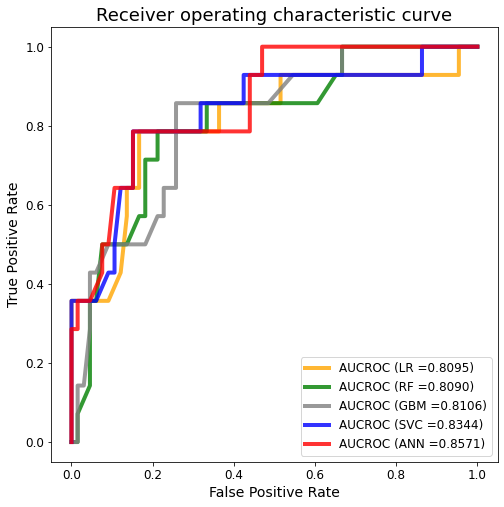

In [60]:
plt.plot(fpr_lr, tpr_lr, color='orange', label='AUCROC (LR ={:.4f})'.format(auc_lr),lw=4, alpha=.8)
plt.plot(fpr_rf, tpr_rf, color='green', label='AUCROC (RF ={:.4f})'.format(auc_rf),lw=4, alpha=.8)
plt.plot(fpr_gbm, tpr_gbm, color='gray', label='AUCROC (GBM ={:.4f})'.format(auc_gbm),lw=4, alpha=.8)
plt.plot(fpr_svc, tpr_svc, color='blue', label='AUCROC (SVC ={:.4f})'.format(auc_svc),lw=4, alpha=.8)
plt.plot(fpr_NL, tpr_NL, color='red', label='AUCROC (ANN ={:.4f})'.format(auc_NL),lw=4, alpha=.8)

plt.rcParams['figure.figsize'] = [8, 8]
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve_20200528.tif', dpi=300)
plt.show()

Combining PR curves of different machine learning methods

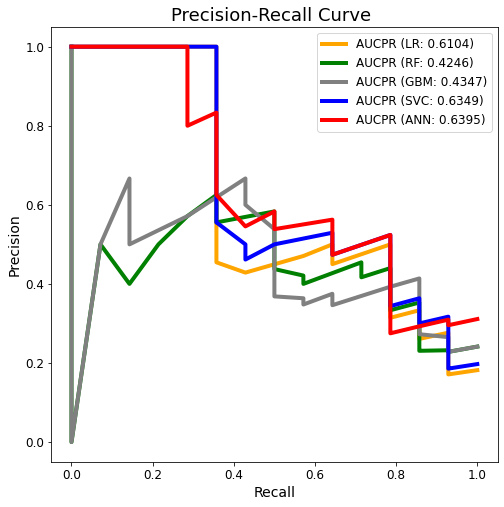

In [61]:
plt.plot(recall_lr, precision_lr, linewidth=4, color='orange',label='AUCPR (LR: {:.4f})'.format(auc_lr_pr))
plt.plot(recall_rf, precision_rf, linewidth=4, color='green',label='AUCPR (RF: {:.4f})'.format(auc_rf_pr))
plt.plot(recall_gbm, precision_gbm, linewidth=4,color='gray', label='AUCPR (GBM: {:.4f})'.format(auc_gbm_pr))
plt.plot(recall_svc, precision_svc, linewidth=4,color='blue', label='AUCPR (SVC: {:.4f})'.format(auc_svc_pr))
plt.plot(recall_NL, precision_NL, linewidth=4,color='red', label='AUCPR (ANN: {:.4f})'.format(auc_NL_pr))


#plt.plot([0, 1], [0.1, 0.1], 'k--')
plt.axis([-0.05, 1.05, -0.05, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12).get_frame().set_facecolor('white')
plt.legend(loc="upper right")
plt.title('{} '.format('Precision-Recall Curve'))
plt.savefig('PR_curve_20200528.tif', dpi=300)
plt.show()

# Deep learning 10-fold cross validation test

In [62]:
tprs_ANN = []
#aucs_ANN = []
tprs_lr = []
#aucs_lr = []
tprs_rf = []
#aucs_rf = []
tprs_gbm = []
#aucs_gbm = []
tprs_svc = []
#aucs_svc = []
mean_fpr_ANN = np.linspace(0, 1, 100)
mean_fpr_lr = np.linspace(0, 1, 100)
mean_fpr_rf = np.linspace(0, 1, 100)
mean_fpr_gbm = np.linspace(0, 1, 100)
mean_fpr_svc = np.linspace(0, 1, 100)
#accus_ANN=[]
#accus_lr=[]
#accus_rf=[]
#accus_gbm=[]
#accus_svc=[]
#aps_ANN=[]
#aps_lr=[]
#aps_rf=[]
#aps_gbm=[]
#aps_svc=[]
#auc_ANN_pr_all=[]
#auc_lr_pr_all=[]
#auc_rf_pr_all=[]
#auc_gbm_pr_all=[]
#auc_svc_pr_all=[]

In [63]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_ANN=[]
roc_auc_ANN=[]
auc_ANN_pr_all=[]
ap_ANN_pr_all=[]
for train, test in kfold.split(X, Y):
   # create model
    model=tf.keras.models.load_model('./finalmodel/ANN_model.h5')
    #model = tf.keras.Sequential([
    #  tf.keras.layers.Dense(50, activation='relu', input_shape=(train_Features.shape[-1],)),
    #  tf.keras.layers.Dropout(0.3),
    #  tf.keras.layers.Dense(50, activation='relu'),
    #  tf.keras.layers.Dropout(0.3),
    #  tf.keras.layers.Dense(150, activation='relu'),
    #  tf.keras.layers.Dense(1, activation='sigmoid')])

    #model.compile(
    #  optimizer=tf.keras.optimizers.Adam(),
    #  loss=tf.keras.losses.BinaryCrossentropy(),
    #  metrics=[tf.keras.metrics.AUC()]
    #)
    unique, counts=numpy.unique(Y[train], return_counts=True)
    severe=counts[1]
    mild=counts[0]
    weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
    weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    
    # Fit the model
    model.fit(X[train],Y[train], 
          epochs=300, batch_size=20, class_weight=class_weight, verbose=2)
    
    
    
    test_probability=model.predict(X[test])
    pred_proba_ANN = np.reshape(test_probability,test_probability.shape[0])
    
    yhat = model.predict_classes(X[test])
    
    fpr_ANN, tpr_ANN, thresholds_ANN = roc_curve(Y[test], pred_proba_ANN)
    tprs_ANN.append(interp(mean_fpr_ANN, fpr_ANN, tpr_ANN))
    tprs_ANN[-1][0] = 0.0
    
    accu_ANN = balanced_accuracy_score(Y[test], model.predict_classes(X[test]))
    auc_ANN = roc_auc_score(Y[test],  pred_proba_ANN)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_ANN)
    # calculate precision-recall AUC
    auc_ANN_pr=auc(recall, precision)
    # calculate average precision score
    ap_ANN_pr= average_precision_score(Y[test], pred_proba_ANN)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_ANN.append(accu_ANN)
    roc_auc_ANN.append(auc_ANN)
    auc_ANN_pr_all.append(auc_ANN_pr)
    ap_ANN_pr_all.append(ap_ANN_pr)

Train on 718 samples
Epoch 1/300
718/718 - 1s - loss: 0.4571 - auc_1: 0.8572
Epoch 2/300
718/718 - 0s - loss: 0.4556 - auc_1: 0.8553
Epoch 3/300
718/718 - 0s - loss: 0.4617 - auc_1: 0.8517
Epoch 4/300
718/718 - 0s - loss: 0.4617 - auc_1: 0.8534
Epoch 5/300
718/718 - 0s - loss: 0.4496 - auc_1: 0.8628
Epoch 6/300
718/718 - 0s - loss: 0.4669 - auc_1: 0.8495
Epoch 7/300
718/718 - 0s - loss: 0.4528 - auc_1: 0.8579
Epoch 8/300
718/718 - 0s - loss: 0.4523 - auc_1: 0.8559
Epoch 9/300
718/718 - 0s - loss: 0.4664 - auc_1: 0.8466
Epoch 10/300
718/718 - 0s - loss: 0.4639 - auc_1: 0.8496
Epoch 11/300
718/718 - 0s - loss: 0.4618 - auc_1: 0.8501
Epoch 12/300
718/718 - 0s - loss: 0.4453 - auc_1: 0.8647
Epoch 13/300
718/718 - 0s - loss: 0.4626 - auc_1: 0.8472
Epoch 14/300
718/718 - 0s - loss: 0.4542 - auc_1: 0.8549
Epoch 15/300
718/718 - 0s - loss: 0.4349 - auc_1: 0.8695
Epoch 16/300
718/718 - 0s - loss: 0.4485 - auc_1: 0.8573
Epoch 17/300
718/718 - 0s - loss: 0.4591 - auc_1: 0.8568
Epoch 18/300
718/71

Epoch 144/300
718/718 - 0s - loss: 0.4528 - auc_1: 0.8573
Epoch 145/300
718/718 - 0s - loss: 0.4486 - auc_1: 0.8608
Epoch 146/300
718/718 - 0s - loss: 0.4388 - auc_1: 0.8643
Epoch 147/300
718/718 - 0s - loss: 0.4446 - auc_1: 0.8591
Epoch 148/300
718/718 - 0s - loss: 0.4438 - auc_1: 0.8646
Epoch 149/300
718/718 - 0s - loss: 0.4497 - auc_1: 0.8580
Epoch 150/300
718/718 - 0s - loss: 0.4378 - auc_1: 0.8651
Epoch 151/300
718/718 - 0s - loss: 0.4387 - auc_1: 0.8721
Epoch 152/300
718/718 - 0s - loss: 0.4463 - auc_1: 0.8625
Epoch 153/300
718/718 - 0s - loss: 0.4429 - auc_1: 0.8659
Epoch 154/300
718/718 - 0s - loss: 0.4574 - auc_1: 0.8555
Epoch 155/300
718/718 - 0s - loss: 0.4406 - auc_1: 0.8719
Epoch 156/300
718/718 - 0s - loss: 0.4400 - auc_1: 0.8658
Epoch 157/300
718/718 - 0s - loss: 0.4419 - auc_1: 0.8669
Epoch 158/300
718/718 - 0s - loss: 0.4459 - auc_1: 0.8648
Epoch 159/300
718/718 - 0s - loss: 0.4532 - auc_1: 0.8586
Epoch 160/300
718/718 - 0s - loss: 0.4436 - auc_1: 0.8676
Epoch 161/300


Epoch 286/300
718/718 - 0s - loss: 0.4387 - auc_1: 0.8659
Epoch 287/300
718/718 - 0s - loss: 0.4408 - auc_1: 0.8644
Epoch 288/300
718/718 - 0s - loss: 0.4380 - auc_1: 0.8657
Epoch 289/300
718/718 - 0s - loss: 0.4601 - auc_1: 0.8543
Epoch 290/300
718/718 - 0s - loss: 0.4335 - auc_1: 0.8714
Epoch 291/300
718/718 - 0s - loss: 0.4342 - auc_1: 0.8689
Epoch 292/300
718/718 - 0s - loss: 0.4325 - auc_1: 0.8701
Epoch 293/300
718/718 - 0s - loss: 0.4263 - auc_1: 0.8731
Epoch 294/300
718/718 - 0s - loss: 0.4481 - auc_1: 0.8627
Epoch 295/300
718/718 - 0s - loss: 0.4530 - auc_1: 0.8562
Epoch 296/300
718/718 - 0s - loss: 0.4523 - auc_1: 0.8536
Epoch 297/300
718/718 - 0s - loss: 0.4657 - auc_1: 0.8506
Epoch 298/300
718/718 - 0s - loss: 0.4386 - auc_1: 0.8681
Epoch 299/300
718/718 - 0s - loss: 0.4497 - auc_1: 0.8608
Epoch 300/300
718/718 - 0s - loss: 0.4457 - auc_1: 0.8617
Train on 718 samples
Epoch 1/300
718/718 - 1s - loss: 0.4622 - auc_1: 0.8535
Epoch 2/300
718/718 - 0s - loss: 0.4500 - auc_1: 0.86

Epoch 129/300
718/718 - 0s - loss: 0.4470 - auc_1: 0.8600
Epoch 130/300
718/718 - 0s - loss: 0.4554 - auc_1: 0.8568
Epoch 131/300
718/718 - 0s - loss: 0.4379 - auc_1: 0.8697
Epoch 132/300
718/718 - 0s - loss: 0.4315 - auc_1: 0.8699
Epoch 133/300
718/718 - 0s - loss: 0.4379 - auc_1: 0.8660
Epoch 134/300
718/718 - 0s - loss: 0.4489 - auc_1: 0.8605
Epoch 135/300
718/718 - 0s - loss: 0.4459 - auc_1: 0.8578
Epoch 136/300
718/718 - 0s - loss: 0.4477 - auc_1: 0.8595
Epoch 137/300
718/718 - 0s - loss: 0.4393 - auc_1: 0.8644
Epoch 138/300
718/718 - 0s - loss: 0.4594 - auc_1: 0.8557
Epoch 139/300
718/718 - 0s - loss: 0.4380 - auc_1: 0.8673
Epoch 140/300
718/718 - 0s - loss: 0.4405 - auc_1: 0.8653
Epoch 141/300
718/718 - 0s - loss: 0.4409 - auc_1: 0.8642
Epoch 142/300
718/718 - 0s - loss: 0.4413 - auc_1: 0.8650
Epoch 143/300
718/718 - 0s - loss: 0.4414 - auc_1: 0.8638
Epoch 144/300
718/718 - 0s - loss: 0.4483 - auc_1: 0.8606
Epoch 145/300
718/718 - 0s - loss: 0.4207 - auc_1: 0.8792
Epoch 146/300


Epoch 271/300
718/718 - 0s - loss: 0.4466 - auc_1: 0.8639
Epoch 272/300
718/718 - 0s - loss: 0.4373 - auc_1: 0.8692
Epoch 273/300
718/718 - 0s - loss: 0.4265 - auc_1: 0.8760
Epoch 274/300
718/718 - 0s - loss: 0.4351 - auc_1: 0.8684
Epoch 275/300
718/718 - 0s - loss: 0.4336 - auc_1: 0.8679
Epoch 276/300
718/718 - 0s - loss: 0.4384 - auc_1: 0.8625
Epoch 277/300
718/718 - 0s - loss: 0.4357 - auc_1: 0.8696
Epoch 278/300
718/718 - 0s - loss: 0.4339 - auc_1: 0.8697
Epoch 279/300
718/718 - 0s - loss: 0.4423 - auc_1: 0.8623
Epoch 280/300
718/718 - 0s - loss: 0.4462 - auc_1: 0.8637
Epoch 281/300
718/718 - 0s - loss: 0.4472 - auc_1: 0.8606
Epoch 282/300
718/718 - 0s - loss: 0.4320 - auc_1: 0.8706
Epoch 283/300
718/718 - 0s - loss: 0.4535 - auc_1: 0.8535
Epoch 284/300
718/718 - 0s - loss: 0.4275 - auc_1: 0.8724
Epoch 285/300
718/718 - 0s - loss: 0.4392 - auc_1: 0.8633
Epoch 286/300
718/718 - 0s - loss: 0.4276 - auc_1: 0.8727
Epoch 287/300
718/718 - 0s - loss: 0.4418 - auc_1: 0.8661
Epoch 288/300


Epoch 114/300
718/718 - 0s - loss: 0.4371 - auc_1: 0.8662
Epoch 115/300
718/718 - 0s - loss: 0.4333 - auc_1: 0.8697
Epoch 116/300
718/718 - 0s - loss: 0.4465 - auc_1: 0.8589
Epoch 117/300
718/718 - 0s - loss: 0.4321 - auc_1: 0.8674
Epoch 118/300
718/718 - 0s - loss: 0.4492 - auc_1: 0.8512
Epoch 119/300
718/718 - 0s - loss: 0.4247 - auc_1: 0.8761
Epoch 120/300
718/718 - 0s - loss: 0.4426 - auc_1: 0.8674
Epoch 121/300
718/718 - 0s - loss: 0.4410 - auc_1: 0.8636
Epoch 122/300
718/718 - 0s - loss: 0.4346 - auc_1: 0.8709
Epoch 123/300
718/718 - 0s - loss: 0.4296 - auc_1: 0.8711
Epoch 124/300
718/718 - 0s - loss: 0.4339 - auc_1: 0.8688
Epoch 125/300
718/718 - 0s - loss: 0.4333 - auc_1: 0.8675
Epoch 126/300
718/718 - 0s - loss: 0.4354 - auc_1: 0.8632
Epoch 127/300
718/718 - 0s - loss: 0.4346 - auc_1: 0.8681
Epoch 128/300
718/718 - 0s - loss: 0.4373 - auc_1: 0.8660
Epoch 129/300
718/718 - 0s - loss: 0.4341 - auc_1: 0.8713
Epoch 130/300
718/718 - 0s - loss: 0.4291 - auc_1: 0.8689
Epoch 131/300


Epoch 256/300
718/718 - 0s - loss: 0.4305 - auc_1: 0.8689
Epoch 257/300
718/718 - 0s - loss: 0.4353 - auc_1: 0.8668
Epoch 258/300
718/718 - 0s - loss: 0.4328 - auc_1: 0.8733
Epoch 259/300
718/718 - 0s - loss: 0.4234 - auc_1: 0.8724
Epoch 260/300
718/718 - 0s - loss: 0.4318 - auc_1: 0.8669
Epoch 261/300
718/718 - 0s - loss: 0.4332 - auc_1: 0.8692
Epoch 262/300
718/718 - 0s - loss: 0.4299 - auc_1: 0.8667
Epoch 263/300
718/718 - 0s - loss: 0.4202 - auc_1: 0.8758
Epoch 264/300
718/718 - 0s - loss: 0.4353 - auc_1: 0.8638
Epoch 265/300
718/718 - 0s - loss: 0.4341 - auc_1: 0.8669
Epoch 266/300
718/718 - 0s - loss: 0.4368 - auc_1: 0.8675
Epoch 267/300
718/718 - 0s - loss: 0.4207 - auc_1: 0.8782
Epoch 268/300
718/718 - 0s - loss: 0.4493 - auc_1: 0.8597
Epoch 269/300
718/718 - 0s - loss: 0.4204 - auc_1: 0.8803
Epoch 270/300
718/718 - 0s - loss: 0.4342 - auc_1: 0.8660
Epoch 271/300
718/718 - 0s - loss: 0.4384 - auc_1: 0.8647
Epoch 272/300
718/718 - 0s - loss: 0.4430 - auc_1: 0.8625
Epoch 273/300


Epoch 99/300
718/718 - 0s - loss: 0.4404 - auc_1: 0.8598
Epoch 100/300
718/718 - 0s - loss: 0.4527 - auc_1: 0.8550
Epoch 101/300
718/718 - 0s - loss: 0.4365 - auc_1: 0.8653
Epoch 102/300
718/718 - 0s - loss: 0.4333 - auc_1: 0.8712
Epoch 103/300
718/718 - 0s - loss: 0.4320 - auc_1: 0.8688
Epoch 104/300
718/718 - 0s - loss: 0.4423 - auc_1: 0.8624
Epoch 105/300
718/718 - 0s - loss: 0.4468 - auc_1: 0.8595
Epoch 106/300
718/718 - 0s - loss: 0.4358 - auc_1: 0.8664
Epoch 107/300
718/718 - 0s - loss: 0.4270 - auc_1: 0.8721
Epoch 108/300
718/718 - 0s - loss: 0.4317 - auc_1: 0.8687
Epoch 109/300
718/718 - 0s - loss: 0.4381 - auc_1: 0.8620
Epoch 110/300
718/718 - 0s - loss: 0.4364 - auc_1: 0.8705
Epoch 111/300
718/718 - 0s - loss: 0.4297 - auc_1: 0.8684
Epoch 112/300
718/718 - 0s - loss: 0.4385 - auc_1: 0.8701
Epoch 113/300
718/718 - 0s - loss: 0.4549 - auc_1: 0.8527
Epoch 114/300
718/718 - 0s - loss: 0.4497 - auc_1: 0.8584
Epoch 115/300
718/718 - 0s - loss: 0.4447 - auc_1: 0.8642
Epoch 116/300
7

Epoch 241/300
718/718 - 0s - loss: 0.4380 - auc_1: 0.8638
Epoch 242/300
718/718 - 0s - loss: 0.4267 - auc_1: 0.8730
Epoch 243/300
718/718 - 0s - loss: 0.4338 - auc_1: 0.8650
Epoch 244/300
718/718 - 0s - loss: 0.4340 - auc_1: 0.8666
Epoch 245/300
718/718 - 0s - loss: 0.4268 - auc_1: 0.8734
Epoch 246/300
718/718 - 0s - loss: 0.4437 - auc_1: 0.8640
Epoch 247/300
718/718 - 0s - loss: 0.4242 - auc_1: 0.8773
Epoch 248/300
718/718 - 0s - loss: 0.4292 - auc_1: 0.8707
Epoch 249/300
718/718 - 0s - loss: 0.4299 - auc_1: 0.8695
Epoch 250/300
718/718 - 0s - loss: 0.4346 - auc_1: 0.8657
Epoch 251/300
718/718 - 0s - loss: 0.4360 - auc_1: 0.8702
Epoch 252/300
718/718 - 0s - loss: 0.4663 - auc_1: 0.8558
Epoch 253/300
718/718 - 0s - loss: 0.4432 - auc_1: 0.8615
Epoch 254/300
718/718 - 0s - loss: 0.4368 - auc_1: 0.8678
Epoch 255/300
718/718 - 0s - loss: 0.4339 - auc_1: 0.8712
Epoch 256/300
718/718 - 0s - loss: 0.4497 - auc_1: 0.8567
Epoch 257/300
718/718 - 0s - loss: 0.4304 - auc_1: 0.8700
Epoch 258/300


Epoch 84/300
718/718 - 0s - loss: 0.4327 - auc_1: 0.8716
Epoch 85/300
718/718 - 0s - loss: 0.4441 - auc_1: 0.8654
Epoch 86/300
718/718 - 0s - loss: 0.4379 - auc_1: 0.8706
Epoch 87/300
718/718 - 0s - loss: 0.4323 - auc_1: 0.8743
Epoch 88/300
718/718 - 0s - loss: 0.4390 - auc_1: 0.8680
Epoch 89/300
718/718 - 0s - loss: 0.4577 - auc_1: 0.8597
Epoch 90/300
718/718 - 0s - loss: 0.4398 - auc_1: 0.8702
Epoch 91/300
718/718 - 0s - loss: 0.4402 - auc_1: 0.8659
Epoch 92/300
718/718 - 0s - loss: 0.4450 - auc_1: 0.8688
Epoch 93/300
718/718 - 0s - loss: 0.4365 - auc_1: 0.8724
Epoch 94/300
718/718 - 0s - loss: 0.4322 - auc_1: 0.8734
Epoch 95/300
718/718 - 0s - loss: 0.4366 - auc_1: 0.8707
Epoch 96/300
718/718 - 0s - loss: 0.4350 - auc_1: 0.8725
Epoch 97/300
718/718 - 0s - loss: 0.4272 - auc_1: 0.8786
Epoch 98/300
718/718 - 0s - loss: 0.4309 - auc_1: 0.8749
Epoch 99/300
718/718 - 0s - loss: 0.4323 - auc_1: 0.8726
Epoch 100/300
718/718 - 0s - loss: 0.4408 - auc_1: 0.8706
Epoch 101/300
718/718 - 0s - l

Epoch 226/300
718/718 - 0s - loss: 0.4294 - auc_1: 0.8741
Epoch 227/300
718/718 - 0s - loss: 0.4263 - auc_1: 0.8766
Epoch 228/300
718/718 - 0s - loss: 0.4370 - auc_1: 0.8717
Epoch 229/300
718/718 - 0s - loss: 0.4319 - auc_1: 0.8727
Epoch 230/300
718/718 - 0s - loss: 0.4258 - auc_1: 0.8763
Epoch 231/300
718/718 - 0s - loss: 0.4361 - auc_1: 0.8677
Epoch 232/300
718/718 - 0s - loss: 0.4174 - auc_1: 0.8791
Epoch 233/300
718/718 - 0s - loss: 0.4190 - auc_1: 0.8804
Epoch 234/300
718/718 - 0s - loss: 0.4393 - auc_1: 0.8664
Epoch 235/300
718/718 - 0s - loss: 0.4390 - auc_1: 0.8720
Epoch 236/300
718/718 - 0s - loss: 0.4367 - auc_1: 0.8718
Epoch 237/300
718/718 - 0s - loss: 0.4228 - auc_1: 0.8789
Epoch 238/300
718/718 - 0s - loss: 0.4265 - auc_1: 0.8813
Epoch 239/300
718/718 - 0s - loss: 0.4317 - auc_1: 0.8759
Epoch 240/300
718/718 - 0s - loss: 0.4198 - auc_1: 0.8815
Epoch 241/300
718/718 - 0s - loss: 0.4208 - auc_1: 0.8811
Epoch 242/300
718/718 - 0s - loss: 0.4247 - auc_1: 0.8772
Epoch 243/300


718/718 - 0s - loss: 0.4597 - auc_1: 0.8528
Epoch 69/300
718/718 - 0s - loss: 0.4507 - auc_1: 0.8600
Epoch 70/300
718/718 - 0s - loss: 0.4653 - auc_1: 0.8472
Epoch 71/300
718/718 - 0s - loss: 0.4571 - auc_1: 0.8520
Epoch 72/300
718/718 - 0s - loss: 0.4508 - auc_1: 0.8604
Epoch 73/300
718/718 - 0s - loss: 0.4526 - auc_1: 0.8559
Epoch 74/300
718/718 - 0s - loss: 0.4500 - auc_1: 0.8598
Epoch 75/300
718/718 - 0s - loss: 0.4435 - auc_1: 0.8619
Epoch 76/300
718/718 - 0s - loss: 0.4485 - auc_1: 0.8576
Epoch 77/300
718/718 - 0s - loss: 0.4475 - auc_1: 0.8647
Epoch 78/300
718/718 - 0s - loss: 0.4418 - auc_1: 0.8646
Epoch 79/300
718/718 - 0s - loss: 0.4583 - auc_1: 0.8553
Epoch 80/300
718/718 - 0s - loss: 0.4410 - auc_1: 0.8684
Epoch 81/300
718/718 - 0s - loss: 0.4505 - auc_1: 0.8552
Epoch 82/300
718/718 - 0s - loss: 0.4607 - auc_1: 0.8598
Epoch 83/300
718/718 - 0s - loss: 0.4471 - auc_1: 0.8622
Epoch 84/300
718/718 - 0s - loss: 0.4667 - auc_1: 0.8479
Epoch 85/300
718/718 - 0s - loss: 0.4506 - a

718/718 - 0s - loss: 0.4462 - auc_1: 0.8604
Epoch 211/300
718/718 - 0s - loss: 0.4562 - auc_1: 0.8553
Epoch 212/300
718/718 - 0s - loss: 0.4428 - auc_1: 0.8637
Epoch 213/300
718/718 - 0s - loss: 0.4512 - auc_1: 0.8570
Epoch 214/300
718/718 - 0s - loss: 0.4476 - auc_1: 0.8621
Epoch 215/300
718/718 - 0s - loss: 0.4528 - auc_1: 0.8574
Epoch 216/300
718/718 - 0s - loss: 0.4635 - auc_1: 0.8522
Epoch 217/300
718/718 - 0s - loss: 0.4264 - auc_1: 0.8712
Epoch 218/300
718/718 - 0s - loss: 0.4419 - auc_1: 0.8622
Epoch 219/300
718/718 - 0s - loss: 0.4411 - auc_1: 0.8640
Epoch 220/300
718/718 - 0s - loss: 0.4460 - auc_1: 0.8594
Epoch 221/300
718/718 - 0s - loss: 0.4484 - auc_1: 0.8570
Epoch 222/300
718/718 - 0s - loss: 0.4403 - auc_1: 0.8619
Epoch 223/300
718/718 - 0s - loss: 0.4428 - auc_1: 0.8633
Epoch 224/300
718/718 - 0s - loss: 0.4578 - auc_1: 0.8498
Epoch 225/300
718/718 - 0s - loss: 0.4574 - auc_1: 0.8523
Epoch 226/300
718/718 - 0s - loss: 0.4472 - auc_1: 0.8547
Epoch 227/300
718/718 - 0s -

718/718 - 0s - loss: 0.4486 - auc_1: 0.8611
Epoch 53/300
718/718 - 0s - loss: 0.4440 - auc_1: 0.8639
Epoch 54/300
718/718 - 0s - loss: 0.4273 - auc_1: 0.8752
Epoch 55/300
718/718 - 0s - loss: 0.4297 - auc_1: 0.8712
Epoch 56/300
718/718 - 0s - loss: 0.4453 - auc_1: 0.8650
Epoch 57/300
718/718 - 0s - loss: 0.4462 - auc_1: 0.8619
Epoch 58/300
718/718 - 0s - loss: 0.4465 - auc_1: 0.8628
Epoch 59/300
718/718 - 0s - loss: 0.4351 - auc_1: 0.8688
Epoch 60/300
718/718 - 0s - loss: 0.4413 - auc_1: 0.8680
Epoch 61/300
718/718 - 0s - loss: 0.4287 - auc_1: 0.8745
Epoch 62/300
718/718 - 0s - loss: 0.4497 - auc_1: 0.8611
Epoch 63/300
718/718 - 0s - loss: 0.4416 - auc_1: 0.8657
Epoch 64/300
718/718 - 0s - loss: 0.4397 - auc_1: 0.8684
Epoch 65/300
718/718 - 0s - loss: 0.4544 - auc_1: 0.8654
Epoch 66/300
718/718 - 0s - loss: 0.4569 - auc_1: 0.8580
Epoch 67/300
718/718 - 0s - loss: 0.4342 - auc_1: 0.8724
Epoch 68/300
718/718 - 0s - loss: 0.4368 - auc_1: 0.8652
Epoch 69/300
718/718 - 0s - loss: 0.4353 - a

Epoch 195/300
718/718 - 0s - loss: 0.4435 - auc_1: 0.8620
Epoch 196/300
718/718 - 0s - loss: 0.4271 - auc_1: 0.8712
Epoch 197/300
718/718 - 0s - loss: 0.4214 - auc_1: 0.8759
Epoch 198/300
718/718 - 0s - loss: 0.4336 - auc_1: 0.8693
Epoch 199/300
718/718 - 0s - loss: 0.4275 - auc_1: 0.8699
Epoch 200/300
718/718 - 0s - loss: 0.4294 - auc_1: 0.8695
Epoch 201/300
718/718 - 0s - loss: 0.4571 - auc_1: 0.8678
Epoch 202/300
718/718 - 0s - loss: 0.4413 - auc_1: 0.8636
Epoch 203/300
718/718 - 0s - loss: 0.4386 - auc_1: 0.8725
Epoch 204/300
718/718 - 0s - loss: 0.4309 - auc_1: 0.8681
Epoch 205/300
718/718 - 0s - loss: 0.4366 - auc_1: 0.8627
Epoch 206/300
718/718 - 0s - loss: 0.4320 - auc_1: 0.8699
Epoch 207/300
718/718 - 0s - loss: 0.4278 - auc_1: 0.8725
Epoch 208/300
718/718 - 0s - loss: 0.4331 - auc_1: 0.8698
Epoch 209/300
718/718 - 0s - loss: 0.4383 - auc_1: 0.8676
Epoch 210/300
718/718 - 0s - loss: 0.4305 - auc_1: 0.8721
Epoch 211/300
718/718 - 0s - loss: 0.4416 - auc_1: 0.8634
Epoch 212/300


Epoch 37/300
718/718 - 0s - loss: 0.4603 - auc_1: 0.8520
Epoch 38/300
718/718 - 0s - loss: 0.4691 - auc_1: 0.8454
Epoch 39/300
718/718 - 0s - loss: 0.4592 - auc_1: 0.8532
Epoch 40/300
718/718 - 0s - loss: 0.4666 - auc_1: 0.8502
Epoch 41/300
718/718 - 0s - loss: 0.4565 - auc_1: 0.8535
Epoch 42/300
718/718 - 0s - loss: 0.4570 - auc_1: 0.8541
Epoch 43/300
718/718 - 0s - loss: 0.4606 - auc_1: 0.8542
Epoch 44/300
718/718 - 0s - loss: 0.4513 - auc_1: 0.8558
Epoch 45/300
718/718 - 0s - loss: 0.4610 - auc_1: 0.8538
Epoch 46/300
718/718 - 0s - loss: 0.4508 - auc_1: 0.8564
Epoch 47/300
718/718 - 0s - loss: 0.4384 - auc_1: 0.8634
Epoch 48/300
718/718 - 0s - loss: 0.4433 - auc_1: 0.8659
Epoch 49/300
718/718 - 0s - loss: 0.4441 - auc_1: 0.8607
Epoch 50/300
718/718 - 0s - loss: 0.4580 - auc_1: 0.8501
Epoch 51/300
718/718 - 0s - loss: 0.4530 - auc_1: 0.8576
Epoch 52/300
718/718 - 0s - loss: 0.4502 - auc_1: 0.8582
Epoch 53/300
718/718 - 0s - loss: 0.4493 - auc_1: 0.8613
Epoch 54/300
718/718 - 0s - los

Epoch 180/300
718/718 - 0s - loss: 0.4351 - auc_1: 0.8662
Epoch 181/300
718/718 - 0s - loss: 0.4504 - auc_1: 0.8554
Epoch 182/300
718/718 - 0s - loss: 0.4432 - auc_1: 0.8610
Epoch 183/300
718/718 - 0s - loss: 0.4459 - auc_1: 0.8589
Epoch 184/300
718/718 - 0s - loss: 0.4465 - auc_1: 0.8535
Epoch 185/300
718/718 - 0s - loss: 0.4307 - auc_1: 0.8704
Epoch 186/300
718/718 - 0s - loss: 0.4348 - auc_1: 0.8687
Epoch 187/300
718/718 - 0s - loss: 0.4512 - auc_1: 0.8591
Epoch 188/300
718/718 - 0s - loss: 0.4565 - auc_1: 0.8583
Epoch 189/300
718/718 - 0s - loss: 0.4339 - auc_1: 0.8719
Epoch 190/300
718/718 - 0s - loss: 0.4348 - auc_1: 0.8670
Epoch 191/300
718/718 - 0s - loss: 0.4373 - auc_1: 0.8626
Epoch 192/300
718/718 - 0s - loss: 0.4538 - auc_1: 0.8571
Epoch 193/300
718/718 - 0s - loss: 0.4484 - auc_1: 0.8555
Epoch 194/300
718/718 - 0s - loss: 0.4418 - auc_1: 0.8608
Epoch 195/300
718/718 - 0s - loss: 0.4427 - auc_1: 0.8584
Epoch 196/300
718/718 - 0s - loss: 0.4533 - auc_1: 0.8576
Epoch 197/300


Epoch 22/300
719/719 - 0s - loss: 0.4509 - auc_1: 0.8583
Epoch 23/300
719/719 - 0s - loss: 0.4524 - auc_1: 0.8563
Epoch 24/300
719/719 - 0s - loss: 0.4314 - auc_1: 0.8710
Epoch 25/300
719/719 - 0s - loss: 0.4352 - auc_1: 0.8693
Epoch 26/300
719/719 - 0s - loss: 0.4476 - auc_1: 0.8589
Epoch 27/300
719/719 - 0s - loss: 0.4450 - auc_1: 0.8616
Epoch 28/300
719/719 - 0s - loss: 0.4645 - auc_1: 0.8500
Epoch 29/300
719/719 - 0s - loss: 0.4450 - auc_1: 0.8622
Epoch 30/300
719/719 - 0s - loss: 0.4741 - auc_1: 0.8442
Epoch 31/300
719/719 - 0s - loss: 0.4497 - auc_1: 0.8622
Epoch 32/300
719/719 - 0s - loss: 0.4430 - auc_1: 0.8627
Epoch 33/300
719/719 - 0s - loss: 0.4597 - auc_1: 0.8614
Epoch 34/300
719/719 - 0s - loss: 0.4639 - auc_1: 0.8553
Epoch 35/300
719/719 - 0s - loss: 0.4454 - auc_1: 0.8617
Epoch 36/300
719/719 - 0s - loss: 0.4517 - auc_1: 0.8557
Epoch 37/300
719/719 - 0s - loss: 0.4319 - auc_1: 0.8694
Epoch 38/300
719/719 - 0s - loss: 0.4377 - auc_1: 0.8654
Epoch 39/300
719/719 - 0s - los

Epoch 165/300
719/719 - 0s - loss: 0.4428 - auc_1: 0.8647
Epoch 166/300
719/719 - 0s - loss: 0.4432 - auc_1: 0.8630
Epoch 167/300
719/719 - 0s - loss: 0.4177 - auc_1: 0.8759
Epoch 168/300
719/719 - 0s - loss: 0.4537 - auc_1: 0.8642
Epoch 169/300
719/719 - 0s - loss: 0.4389 - auc_1: 0.8662
Epoch 170/300
719/719 - 0s - loss: 0.4344 - auc_1: 0.8686
Epoch 171/300
719/719 - 0s - loss: 0.4482 - auc_1: 0.8586
Epoch 172/300
719/719 - 0s - loss: 0.4373 - auc_1: 0.8675
Epoch 173/300
719/719 - 0s - loss: 0.4294 - auc_1: 0.8719
Epoch 174/300
719/719 - 0s - loss: 0.4414 - auc_1: 0.8622
Epoch 175/300
719/719 - 0s - loss: 0.4300 - auc_1: 0.8675
Epoch 176/300
719/719 - 0s - loss: 0.4348 - auc_1: 0.8675
Epoch 177/300
719/719 - 0s - loss: 0.4352 - auc_1: 0.8718
Epoch 178/300
719/719 - 0s - loss: 0.4377 - auc_1: 0.8644
Epoch 179/300
719/719 - 0s - loss: 0.4344 - auc_1: 0.8712
Epoch 180/300
719/719 - 0s - loss: 0.4399 - auc_1: 0.8603
Epoch 181/300
719/719 - 0s - loss: 0.4339 - auc_1: 0.8724
Epoch 182/300


719/719 - 0s - loss: 0.4460 - auc_1: 0.8634
Epoch 7/300
719/719 - 0s - loss: 0.4518 - auc_1: 0.8562
Epoch 8/300
719/719 - 0s - loss: 0.4397 - auc_1: 0.8678
Epoch 9/300
719/719 - 0s - loss: 0.4641 - auc_1: 0.8523
Epoch 10/300
719/719 - 0s - loss: 0.4388 - auc_1: 0.8669
Epoch 11/300
719/719 - 0s - loss: 0.4469 - auc_1: 0.8647
Epoch 12/300
719/719 - 0s - loss: 0.4483 - auc_1: 0.8609
Epoch 13/300
719/719 - 0s - loss: 0.4534 - auc_1: 0.8581
Epoch 14/300
719/719 - 0s - loss: 0.4353 - auc_1: 0.8699
Epoch 15/300
719/719 - 0s - loss: 0.4483 - auc_1: 0.8607
Epoch 16/300
719/719 - 0s - loss: 0.4424 - auc_1: 0.8670
Epoch 17/300
719/719 - 0s - loss: 0.4543 - auc_1: 0.8594
Epoch 18/300
719/719 - 0s - loss: 0.4471 - auc_1: 0.8637
Epoch 19/300
719/719 - 0s - loss: 0.4560 - auc_1: 0.8563
Epoch 20/300
719/719 - 0s - loss: 0.4339 - auc_1: 0.8714
Epoch 21/300
719/719 - 0s - loss: 0.4366 - auc_1: 0.8668
Epoch 22/300
719/719 - 0s - loss: 0.4515 - auc_1: 0.8564
Epoch 23/300
719/719 - 0s - loss: 0.4479 - auc_

719/719 - 0s - loss: 0.4314 - auc_1: 0.8733
Epoch 150/300
719/719 - 0s - loss: 0.4387 - auc_1: 0.8650
Epoch 151/300
719/719 - 0s - loss: 0.4507 - auc_1: 0.8573
Epoch 152/300
719/719 - 0s - loss: 0.4399 - auc_1: 0.8676
Epoch 153/300
719/719 - 0s - loss: 0.4395 - auc_1: 0.8674
Epoch 154/300
719/719 - 0s - loss: 0.4374 - auc_1: 0.8674
Epoch 155/300
719/719 - 0s - loss: 0.4261 - auc_1: 0.8750
Epoch 156/300
719/719 - 0s - loss: 0.4372 - auc_1: 0.8682
Epoch 157/300
719/719 - 0s - loss: 0.4513 - auc_1: 0.8588
Epoch 158/300
719/719 - 0s - loss: 0.4456 - auc_1: 0.8623
Epoch 159/300
719/719 - 0s - loss: 0.4653 - auc_1: 0.8525
Epoch 160/300
719/719 - 0s - loss: 0.4326 - auc_1: 0.8730
Epoch 161/300
719/719 - 0s - loss: 0.4472 - auc_1: 0.8583
Epoch 162/300
719/719 - 0s - loss: 0.4372 - auc_1: 0.8690
Epoch 163/300
719/719 - 0s - loss: 0.4359 - auc_1: 0.8705
Epoch 164/300
719/719 - 0s - loss: 0.4241 - auc_1: 0.8781
Epoch 165/300
719/719 - 0s - loss: 0.4438 - auc_1: 0.8656
Epoch 166/300
719/719 - 0s -

Epoch 291/300
719/719 - 0s - loss: 0.4418 - auc_1: 0.8617
Epoch 292/300
719/719 - 0s - loss: 0.4233 - auc_1: 0.8731
Epoch 293/300
719/719 - 0s - loss: 0.4393 - auc_1: 0.8704
Epoch 294/300
719/719 - 0s - loss: 0.4319 - auc_1: 0.8725
Epoch 295/300
719/719 - 0s - loss: 0.4362 - auc_1: 0.8705
Epoch 296/300
719/719 - 0s - loss: 0.4331 - auc_1: 0.8705
Epoch 297/300
719/719 - 0s - loss: 0.4329 - auc_1: 0.8685
Epoch 298/300
719/719 - 0s - loss: 0.4291 - auc_1: 0.8737
Epoch 299/300
719/719 - 0s - loss: 0.4242 - auc_1: 0.8763
Epoch 300/300
719/719 - 0s - loss: 0.4334 - auc_1: 0.8724


In [64]:
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_ANN)*100, numpy.std(scores_ANN)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_ANN)*100, numpy.std(roc_auc_ANN)*100))
#print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_NL)*100, numpy.std(f1_NL)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_ANN_pr_all)*100, numpy.std(auc_ANN_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_ANN_pr_all)*100, numpy.std(ap_ANN_pr_all)*100))

scores=75.85% (+/- 4.71%)
roc_auc=83.45% (+/- 3.93%)
auc=51.91% (+/- 12.03%)
ap=54.60% (+/- 11.05%)


# Logistic regression 10-fold cross validation test

In [65]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_lr=[]
roc_auc_lr=[]
f1_lr=[]
auc_lr_pr_all=[]
ap_lr_pr_all=[]
for train, test in kfold.split(X, Y):
    # Import model and retrain
    with open('20200225lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(X[train], Y[train])

    
    accu_lr = balanced_accuracy_score(Y[test], lr_clf.predict(X[test]))
   # create model
    pred_proba_lr = lr_clf.predict_proba(X[test])
    pred_proba_lr = pred_proba_lr[:, 1]
    yhat = lr_clf.predict(X[test])
    
    fpr_lr, tpr_lr, thresholds_lr = roc_curve(Y[test],  pred_proba_lr)
    tprs_lr.append(interp(mean_fpr_lr, fpr_lr, tpr_lr))
    tprs_lr[-1][0] = 0.0
    
    auc_lr = roc_auc_score(Y[test],  pred_proba_lr)
    
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_lr)
    # calculate F1 score
    f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
    auc_lr_pr=auc(recall, precision)
    # calculate average precision score
    ap_lr_pr= average_precision_score(Y[test], pred_proba_lr)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    scores_lr.append( accu_lr )
    roc_auc_lr.append( auc_lr )
    f1_lr.append( f1)
    auc_lr_pr_all.append(auc_lr_pr)
    ap_lr_pr_all.append(ap_lr_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_lr)*100, numpy.std(scores_lr)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_lr)*100, numpy.std(roc_auc_lr)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_lr)*100, numpy.std(f1_lr)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_lr_pr_all)*100, numpy.std(auc_lr_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_lr_pr_all)*100, numpy.std(ap_lr_pr_all)*100))

scores=54.25% (+/- 4.68%)
roc_auc=81.35% (+/- 7.18%)
f1=16.06% (+/- 14.08%)
auc=49.02% (+/- 14.28%)
ap=51.66% (+/- 13.36%)


# Random forest 10-fold cross validation test

In [66]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_rf=[]
roc_auc_rf=[]
f1_rf=[]
auc_rf_pr_all=[]
ap_rf_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('./finalmodel/rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
        rf_clf.fit(X[train], Y[train])
    
        accu_rf = balanced_accuracy_score(Y[test], rf_clf.predict(X[test]))
   # create model
        pred_proba_rf = rf_clf.predict_proba(X[test])
        pred_proba_rf = pred_proba_rf[:, 1]
        yhat = rf_clf.predict(X[test])
        auc_rf = roc_auc_score(Y[test],  pred_proba_rf)
        
        fpr_rf, tpr_rf, thresholds_rf = roc_curve(Y[test],  pred_proba_rf)
        tprs_rf.append(interp(mean_fpr_rf, fpr_rf, tpr_rf))
        tprs_rf[-1][0] = 0.0
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_rf)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_rf_pr=auc(recall, precision)
    # calculate average precision score
        ap_rf_pr= average_precision_score(Y[test], pred_proba_rf)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_rf.append( accu_rf )
        roc_auc_rf.append(auc_rf)
        f1_rf.append( f1)
        auc_rf_pr_all.append(auc_rf_pr)
        ap_rf_pr_all.append(ap_rf_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_rf)*100, numpy.std(roc_auc_rf)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=54.48% (+/- 5.43%)
roc_auc=81.71% (+/- 5.43%)
f1=16.49% (+/- 14.82%)
auc=47.31% (+/- 8.75%)
ap=49.25% (+/- 8.68%)


# Gradient boosting machine learning model

In [67]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_gbm=[]
roc_auc_gbm=[]
f1_gbm=[]
auc_gbm_pr_all=[]
ap_gbm_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('./finalmodel/gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
        gbm_clf.fit(X[train], Y[train])
    
        accu_gbm = balanced_accuracy_score(Y[test], gbm_clf.predict(X[test]))
   # create model
        pred_proba_gbm = gbm_clf.predict_proba(X[test])
        pred_proba_gbm = pred_proba_gbm[:, 1]
        yhat = gbm_clf.predict(X[test])
        
        auc_gbm = roc_auc_score(Y[test],  pred_proba_gbm)
        
        fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(Y[test],  pred_proba_gbm)
        tprs_gbm.append(interp(mean_fpr_gbm, fpr_gbm, tpr_gbm))
        tprs_gbm[-1][0] = 0.0
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_gbm)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_gbm_pr=auc(recall, precision)
    # calculate average precision score
        ap_gbm_pr= average_precision_score(Y[test], pred_proba_gbm)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_gbm.append( accu_gbm )
        roc_auc_gbm.append(auc_gbm)
        f1_gbm.append( f1)
        auc_gbm_pr_all.append(auc_gbm_pr)
        ap_gbm_pr_all.append(ap_gbm_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_rf)*100, numpy.std(scores_rf)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_gbm)*100, numpy.std(roc_auc_gbm)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_rf)*100, numpy.std(f1_rf)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_rf_pr_all)*100, numpy.std(auc_rf_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_rf_pr_all)*100, numpy.std(ap_rf_pr_all)*100))

scores=54.48% (+/- 5.43%)
roc_auc=80.90% (+/- 5.94%)
f1=16.49% (+/- 14.82%)
auc=47.31% (+/- 8.75%)
ap=49.25% (+/- 8.68%)


# SVC

In [68]:
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores_svc=[]
roc_auc_svc=[]
f1_svc=[]
auc_svc_pr_all=[]
ap_svc_pr_all=[]
for train, test in kfold.split(X, Y):
  # create model
   with open('./finalmodel/svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
        svc_clf.fit(X[train], Y[train])
    
        accu_svc = balanced_accuracy_score(Y[test], svc_clf.predict(X[test]))
   # create model
        pred_proba_svc = svc_clf.predict_proba(X[test])
        pred_proba_svc = pred_proba_svc[:, 1]
        yhat = svc_clf.predict(X[test])
        
        auc_svc = roc_auc_score(Y[test],  pred_proba_svc)
        
        fpr_svc, tpr_svc, thresholds_svc = roc_curve(Y[test],  pred_proba_svc)
        tprs_svc.append(interp(mean_fpr_svc, fpr_svc, tpr_svc))
        tprs_svc[-1][0] = 0.0
        
    # calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(Y[test], pred_proba_svc)
    # calculate F1 score
        f1 = f1_score(Y[test], yhat)
    # calculate precision-recall AUC
        auc_svc_pr=auc(recall, precision)
    # calculate average precision score
        ap_svc_pr= average_precision_score(Y[test], pred_proba_svc)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
        scores_svc.append( accu_svc )
        roc_auc_svc.append(auc_svc)
        f1_svc.append( f1)
        auc_svc_pr_all.append(auc_svc_pr)
        ap_svc_pr_all.append(ap_svc_pr)
    
print("scores=%.2f%% (+/- %.2f%%)"%  (numpy.mean(scores_svc)*100, numpy.std(scores_svc)*100))
print("roc_auc=%.2f%% (+/- %.2f%%)"%  (numpy.mean(roc_auc_svc)*100, numpy.std(roc_auc_svc)*100))
print("f1=%.2f%% (+/- %.2f%%)" % (numpy.mean(f1_svc)*100, numpy.std(f1_svc)*100))
print("auc=%.2f%% (+/- %.2f%%)" % (numpy.mean(auc_svc_pr_all)*100, numpy.std(auc_svc_pr_all)*100))
print("ap=%.2f%% (+/- %.2f%%)" % (numpy.mean(ap_svc_pr_all)*100, numpy.std(ap_svc_pr_all)*100))

scores=74.85% (+/- 6.88%)
roc_auc=82.17% (+/- 6.24%)
f1=50.19% (+/- 7.49%)
auc=51.54% (+/- 14.16%)
ap=53.82% (+/- 13.27%)


# Copy codes

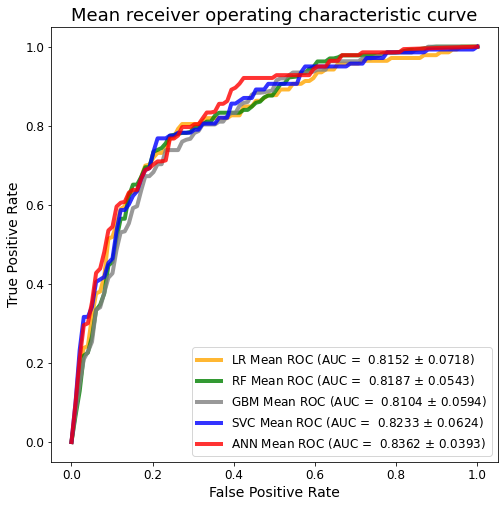

0.7584582084582085
0.5424908424908426
0.5448135198135198
0.5866550116550118
0.7484598734598734
0.5459589339727771
0.5165508287935204
0.4924628864805542
0.47687097741788725
0.5382420087452305


In [69]:

#LR curve
mean_tpr_lr = np.mean(tprs_lr, axis=0)
mean_tpr_lr[-1] = 1.0
mean_auc_lr = sklearn.metrics.auc(mean_fpr_lr, mean_tpr_lr)
std_auc_lr = np.std(roc_auc_lr)
plt.plot(mean_fpr_lr, mean_tpr_lr, color='orange',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('LR', mean_auc_lr, std_auc_lr),  lw=4, alpha=.8)

#std_tpr_lr = np.std(tprs_lr, axis=0)
#tprs_upper_lr = np.minimum(mean_tpr_lr + std_tpr_lr, 1)
#tprs_lower_lr = np.maximum(mean_tpr_lr - std_tpr_lr, 0)
#plt.fill_between(mean_fpr_lr, tprs_lower_lr, tprs_upper_lr, color='g', alpha=.2, label=r'$\pm$ LR 1 std. dev.')

#RF curve
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = sklearn.metrics.auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(roc_auc_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='green',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('RF', mean_auc_rf, std_auc_rf),  lw=4, alpha=.8)

#std_tpr_rf = np.std(tprs_rf, axis=0)
#tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
#tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
#plt.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='y', alpha=.2,
#                 label=r'$\pm$ RF 1 std. dev.')

#GBM curve
mean_tpr_gbm = np.mean(tprs_gbm, axis=0)
mean_tpr_gbm[-1] = 1.0
mean_auc_gbm = sklearn.metrics.auc(mean_fpr_gbm, mean_tpr_gbm)
std_auc_gbm = np.std(roc_auc_gbm)
plt.plot(mean_fpr_gbm, mean_tpr_gbm, color='gray',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('GBM', mean_auc_gbm, std_auc_gbm),  lw=4, alpha=.8)

#std_tpr_gbm = np.std(tprs_gbm, axis=0)
#tprs_upper_gbm = np.minimum(mean_tpr_gbm + std_tpr_gbm, 1)
#tprs_lower_gbm = np.maximum(mean_tpr_gbm - std_tpr_gbm, 0)
#plt.fill_between(mean_fpr_gbm, tprs_lower_gbm, tprs_upper_gbm, color='purple', alpha=.2,
#                 label=r'$\pm$ GBM 1 std. dev.')

#SVC curve
mean_tpr_svc = np.mean(tprs_svc, axis=0)
mean_tpr_svc[-1] = 1.0
mean_auc_svc = sklearn.metrics.auc(mean_fpr_svc, mean_tpr_svc)
std_auc_svc = np.std(roc_auc_svc)
plt.plot(mean_fpr_svc, mean_tpr_svc, color='blue',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('SVC', mean_auc_svc, std_auc_svc),  lw=4, alpha=.8)

#std_tpr_svc = np.std(tprs_svc, axis=0)
#tprs_upper_svc = np.minimum(mean_tpr_svc + std_tpr_svc, 1)
#tprs_lower_svc = np.maximum(mean_tpr_svc - std_tpr_svc, 0)
#plt.fill_between(mean_fpr_svc, tprs_lower_svc, tprs_upper_svc, color='orange', alpha=.2,
#                 label=r'$\pm$ SVC 1 std. dev.')

# ANN curve
mean_tpr_ANN = np.mean(tprs_ANN, axis=0)
mean_tpr_ANN[-1] = 1.0
mean_auc_ANN = sklearn.metrics.auc(mean_fpr_ANN, mean_tpr_ANN)
std_auc_ANN = np.std(roc_auc_ANN)
plt.plot(mean_fpr_ANN, mean_tpr_ANN, color='red',label='% s Mean ROC (AUC =  %0.4f $\pm$ %0.4f)'% ('ANN', mean_auc_ANN, std_auc_ANN),  lw=4, alpha=.8)

#std_tpr_ANN = np.std(tprs_ANN, axis=0)
#tprs_upper_ANN = np.minimum(mean_tpr_ANN + std_tpr_ANN, 1)
#tprs_lower_ANN = np.maximum(mean_tpr_ANN - std_tpr_ANN, 0)
#plt.fill_between(mean_fpr_ANN, tprs_lower_ANN, tprs_upper_ANN, color='blue', alpha=.2,
#                 label=r'$\pm$ ANN 1 std. dev.')



plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.savefig('models_roc_curve_10folds_20200528.tif', dpi=300)
plt.show()
  
print(np.mean(scores_ANN))
print(np.mean(scores_lr))
print(np.mean(scores_rf))
print(np.mean(scores_gbm))
print(np.mean(scores_svc))

print(np.mean(ap_ANN_pr_all))
print(np.mean(ap_lr_pr_all))
print(np.mean(ap_rf_pr_all))
print(np.mean(ap_gbm_pr_all))
print(np.mean(ap_svc_pr_all))

## Summary
Support vector machine, random forests and gradient boosting classifiers are better than Apache 3 and ANZROD in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The Deep learner performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

There are also composite scores that attempt to summarize the precision and recall; three examples include:

F score or F1 score: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

Average precision: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

Area Under Curve: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

In [70]:
Finaldf=pd.DataFrame([[numpy.mean(scores_lr), numpy.mean(scores_svc), numpy.mean(scores_rf), numpy.mean(scores_gbm), numpy.mean(scores_ANN)],
              [numpy.std(scores_lr), numpy.std(scores_svc), numpy.std(scores_rf), numpy.std(scores_gbm), numpy.std(scores_ANN)],
              [mean_auc_lr, mean_auc_svc, mean_auc_rf,mean_auc_gbm, mean_auc_ANN],
              [std_auc_lr, std_auc_svc, std_auc_rf,std_auc_gbm, std_auc_ANN],
              [numpy.mean(auc_lr_pr_all), numpy.mean(auc_svc_pr_all), numpy.mean(auc_rf_pr_all), numpy.mean(auc_gbm_pr_all),  numpy.mean(auc_ANN_pr_all)],
              [numpy.std(auc_lr_pr_all), numpy.std(auc_svc_pr_all), numpy.std(auc_rf_pr_all), numpy.std(auc_gbm_pr_all),  numpy.std(auc_ANN_pr_all)],
              [numpy.mean(ap_lr_pr_all), numpy.mean(ap_svc_pr_all), numpy.mean(ap_rf_pr_all), numpy.mean(ap_gbm_pr_all),  numpy.mean(ap_ANN_pr_all)],
              [numpy.std(ap_lr_pr_all), numpy.std(ap_svc_pr_all), numpy.std(ap_rf_pr_all), numpy.std(ap_gbm_pr_all),  numpy.std(ap_ANN_pr_all)]],
              index=['Balance accuracy','Balance accuracy SD','Area Under (ROC) Curve', 'Area Under (ROC) Curve SD','Area Under (Precision-recall) Curve', 'Area Under (Precision-recall) Curve SD','Average precision score', 'Average precision score SD' ],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine',  'Deep Learner'])

In [71]:
Finaldf

Logistic Regression  \
Balance accuracy                                   0.542491   
Balance accuracy SD                                0.046787   
Area Under (ROC) Curve                             0.815188   
Area Under (ROC) Curve SD                          0.071751   
Area Under (Precision-recall) Curve                0.490238   
Area Under (Precision-recall) Curve SD             0.142758   
Average precision score                            0.516551   
Average precision score SD                         0.133576   

                                        Support vector machine  \
Balance accuracy                                      0.748460   
Balance accuracy SD                                   0.068788   
Area Under (ROC) Curve                                0.823313   
Area Under (ROC) Curve SD                             0.062367   
Area Under (Precision-recall) Curve                   0.515403   
Area Under (Precision-recall) Curve SD                0.141575   
Average precision score                               0.538242   
Average precision score SD                            0.132703   

                                        Random forests  \
Balance accuracy                              0.544814   
Balance accuracy SD                           0.054341   
Area Under (ROC) Curve                        0.818689   
Area Under (ROC) Curve SD                     0.054338   
Area Under (Precision-recall) Curve           0.473100   
Area Under (Precision-recall) Curve SD        0.087479   
Average precision score                       0.492463   
Average precision score SD                    0.086821   

                                        Gradient boosting machine  \
Balance accuracy                                         0.586655   
Balance accuracy SD                                      0.071228   
Area Under (ROC) Curve                                   0.810386   
Area Under (ROC) Curve SD                                0.059432   
Area Under (Precision-recall) Curve                      0.456123   
Area Under (Precision-recall) Curve SD                   0.151518   
Average precision score                                  0.476871   
Average precision score SD                               0.143811   

                                        Deep Learner  
Balance accuracy                            0.758458  
Balance accuracy SD                         0.047068  
Area Under (ROC) Curve                      0.836164  
Area Under (ROC) Curve SD                   0.039261  
Area Under (Precision-recall) Curve         0.519072  
Area Under (Precision-recall) Curve SD      0.120278  
Average precision score                     0.545959  
Average precision score SD                  0.110541

In [72]:
Finaldf.to_csv('20200312finaltable.csv')

# define 10-fold cross validation test harness

# Deep learning model explaination by SHAP

In [73]:
import sklearn
import shap


# print the JS visualization code to the notebook
shap.initjs()

# train a SVM classifier
model=tf.keras.models.load_model('./finalmodel/ANN_model.h5')
#model = keras.Sequential([
#      keras.layers.Dense(50, activation='relu', input_shape=(X_train.shape[-1],)),
#      keras.layers.Dropout(0.3),
#      keras.layers.Dense(50, activation='relu'),
#      keras.layers.Dropout(0.3),
#      keras.layers.Dense(150, activation='relu'),
#      keras.layers.Dense(1, activation='sigmoid')])

#class_weight
unique, counts=np.unique(train_Label, return_counts=True)
severe=counts[1]
mild=counts[0]
weight_for_0 = (1 / counts[0])*(counts.sum())/2.0 
weight_for_1 = (1 / counts[1])*(counts.sum())/2.0

class_weights = {0: weight_for_0, 1: weight_for_1}
      
#model.compile(
#      optimizer=keras.optimizers.Adam(),
#      loss=keras.losses.BinaryCrossentropy(),
#      metrics=[tf.keras.metrics.AUC()])
model.fit(train_Features,train_Label, 
          class_weight=class_weights,
          epochs=300, batch_size=20, verbose=2)

Train on 718 samples
Epoch 1/300
718/718 - 1s - loss: 0.4362 - auc_1: 0.8689
Epoch 2/300
718/718 - 0s - loss: 0.4439 - auc_1: 0.8653
Epoch 3/300
718/718 - 0s - loss: 0.4494 - auc_1: 0.8606
Epoch 4/300
718/718 - 0s - loss: 0.4654 - auc_1: 0.8516
Epoch 5/300
718/718 - 0s - loss: 0.4501 - auc_1: 0.8609
Epoch 6/300
718/718 - 0s - loss: 0.4528 - auc_1: 0.8571
Epoch 7/300
718/718 - 0s - loss: 0.4415 - auc_1: 0.8685
Epoch 8/300
718/718 - 0s - loss: 0.4522 - auc_1: 0.8539
Epoch 9/300
718/718 - 0s - loss: 0.4633 - auc_1: 0.8539
Epoch 10/300
718/718 - 0s - loss: 0.4400 - auc_1: 0.8683
Epoch 11/300
718/718 - 0s - loss: 0.4517 - auc_1: 0.8576
Epoch 12/300
718/718 - 0s - loss: 0.4505 - auc_1: 0.8583
Epoch 13/300
718/718 - 0s - loss: 0.4455 - auc_1: 0.8617
Epoch 14/300
718/718 - 0s - loss: 0.4494 - auc_1: 0.8620
Epoch 15/300
718/718 - 0s - loss: 0.4439 - auc_1: 0.8602
Epoch 16/300
718/718 - 0s - loss: 0.4484 - auc_1: 0.8648
Epoch 17/300
718/718 - 0s - loss: 0.4322 - auc_1: 0.8727
Epoch 18/300
718/71

Epoch 144/300
718/718 - 0s - loss: 0.4523 - auc_1: 0.8585
Epoch 145/300
718/718 - 0s - loss: 0.4371 - auc_1: 0.8681
Epoch 146/300
718/718 - 0s - loss: 0.4346 - auc_1: 0.8682
Epoch 147/300
718/718 - 0s - loss: 0.4372 - auc_1: 0.8699
Epoch 148/300
718/718 - 0s - loss: 0.4346 - auc_1: 0.8707
Epoch 149/300
718/718 - 0s - loss: 0.4488 - auc_1: 0.8653
Epoch 150/300
718/718 - 0s - loss: 0.4378 - auc_1: 0.8669
Epoch 151/300
718/718 - 0s - loss: 0.4369 - auc_1: 0.8664
Epoch 152/300
718/718 - 0s - loss: 0.4572 - auc_1: 0.8553
Epoch 153/300
718/718 - 0s - loss: 0.4459 - auc_1: 0.8623
Epoch 154/300
718/718 - 0s - loss: 0.4441 - auc_1: 0.8588
Epoch 155/300
718/718 - 0s - loss: 0.4407 - auc_1: 0.8663
Epoch 156/300
718/718 - 0s - loss: 0.4328 - auc_1: 0.8706
Epoch 157/300
718/718 - 0s - loss: 0.4325 - auc_1: 0.8710
Epoch 158/300
718/718 - 0s - loss: 0.4330 - auc_1: 0.8670
Epoch 159/300
718/718 - 0s - loss: 0.4371 - auc_1: 0.8679
Epoch 160/300
718/718 - 0s - loss: 0.4344 - auc_1: 0.8679
Epoch 161/300


Epoch 286/300
718/718 - 0s - loss: 0.4499 - auc_1: 0.8603
Epoch 287/300
718/718 - 0s - loss: 0.4366 - auc_1: 0.8664
Epoch 288/300
718/718 - 0s - loss: 0.4338 - auc_1: 0.8696
Epoch 289/300
718/718 - 0s - loss: 0.4289 - auc_1: 0.8698
Epoch 290/300
718/718 - 0s - loss: 0.4328 - auc_1: 0.8709
Epoch 291/300
718/718 - 0s - loss: 0.4350 - auc_1: 0.8676
Epoch 292/300
718/718 - 0s - loss: 0.4358 - auc_1: 0.8682
Epoch 293/300
718/718 - 0s - loss: 0.4250 - auc_1: 0.8796
Epoch 294/300
718/718 - 0s - loss: 0.4293 - auc_1: 0.8724
Epoch 295/300
718/718 - 0s - loss: 0.4307 - auc_1: 0.8724
Epoch 296/300
718/718 - 0s - loss: 0.4375 - auc_1: 0.8657
Epoch 297/300
718/718 - 0s - loss: 0.4404 - auc_1: 0.8644
Epoch 298/300
718/718 - 0s - loss: 0.4325 - auc_1: 0.8705
Epoch 299/300
718/718 - 0s - loss: 0.4331 - auc_1: 0.8683
Epoch 300/300
718/718 - 0s - loss: 0.4306 - auc_1: 0.8672


In [74]:
test_probability=model.predict(test_Features)
pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
#yhat = model.predict_classes(test_Features)

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(model.predict, train_Features)
shap_values = explainer.shap_values(test_Features)

Using 718 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


HBox(children=(FloatProgress(value=0.0, max=80.0), HTML(value='')))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


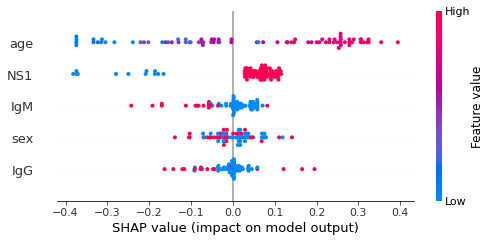

In [75]:
shap.summary_plot(shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Summaryplot.tif', dpi=300)

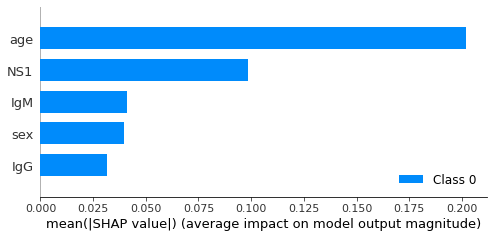

In [76]:
shap.summary_plot(shap_values, test_df.iloc[:,1:6], show=False)
plt.savefig('Summaryplot2.tif', dpi=300)

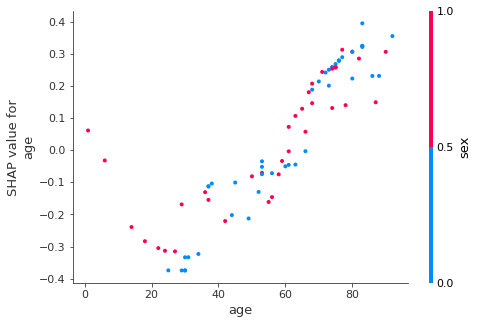

In [77]:
shap.dependence_plot("age", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_age.tif', dpi=300)

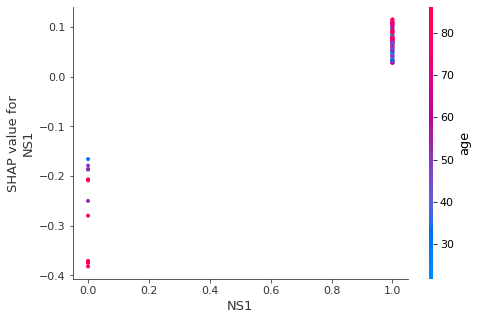

In [78]:
shap.dependence_plot("NS1", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_ns1.tif', dpi=300)

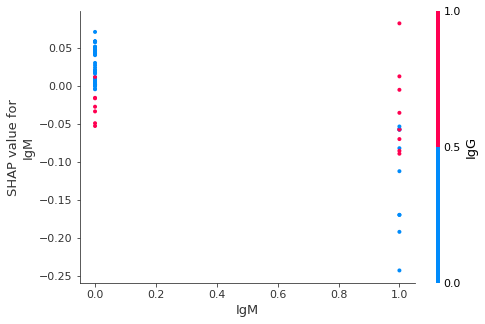

In [79]:
shap.dependence_plot("IgM", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_igm.tif', dpi=300)

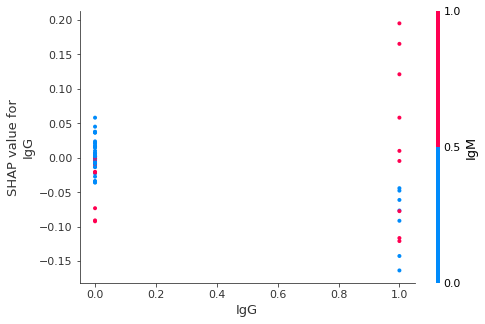

In [80]:
shap.dependence_plot("IgG", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_igg.tif', dpi=300)

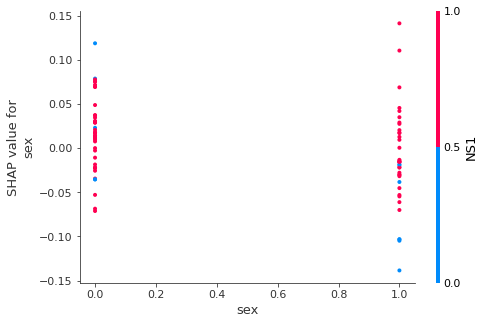

In [81]:
shap.dependence_plot("sex", shap_values[0], test_df.iloc[:,1:6], show=False)
plt.savefig('Dependent_sex.tif', dpi=300)

### Concat prediction_proba for each model to test set, save test set

In [82]:
def pred_proba(train_x, train_y, test_x, test_y, weighted_model):
    data=pd.DataFrame()
    data['severity']= test_y

    with open('./finalmodel/lr_clf_final_round.pkl', 'rb') as f:
        lr_clf = pickle.load(f)
    lr_clf.fit(train_x, train_y)
    pred_proba_lr = lr_clf.predict_proba(test_x)[:, 1]
    data['lr_pred_proba'] = pred_proba_lr


    with open('./finalmodel/rf_clf_final_round.pkl', 'rb') as f:
        rf_clf = pickle.load(f)
    rf_clf.fit(train_x, train_y)
    pred_proba_rf = rf_clf.predict_proba(test_x)[:, 1]
    data['rf_pred_proba'] = pred_proba_rf


    with open('./finalmodel/svc_clf_final_round.pkl', 'rb') as f:
        svc_clf = pickle.load(f)
    svc_clf.fit(train_x, train_y)
    pred_proba_svc = svc_clf.predict_proba(test_x)[:, 1]
    data['svc_pred_proba'] = pred_proba_svc

    with open('./finalmodel/gbm_clf_final_round.pkl', 'rb') as f:
        gbm_clf = pickle.load(f)
    gbm_clf.fit(train_x, train_y)
    pred_proba_gbm = gbm_clf.predict_proba(test_x)[:, 1]
    data['gbm_pred_proba'] = pred_proba_gbm


    #model = keras.Sequential([
    #  keras.layers.Dense(50, activation='relu', input_shape=(train_x.shape[-1],)),
    #  keras.layers.Dropout(0.3),
    #  keras.layers.Dense(150, activation='relu'),
    #  keras.layers.Dropout(0.3),
    #  keras.layers.Dense(150, activation='relu'),
    #  keras.layers.Dense(1, activation='sigmoid')])
      
      
    #model.compile(
    #  optimizer=keras.optimizers.Adam(),
    #  loss=keras.losses.BinaryCrossentropy(),
    #  metrics=[tf.keras.metrics.AUC()])
    #model.fit(train_x,train_y, 
    #      class_weight=class_weights,
    #      epochs=300, batch_size=20, verbose=2)

    test_probability=weighted_model.predict(test_x)
    pred_proba_NL = np.reshape(test_probability,test_probability.shape[0])
    data['NL_pred_proba'] = pred_proba_NL

    return data

In [83]:
data_test=pred_proba(train_Features, train_Label, test_Features, test_Label, model)

In [84]:
data_test

severity  lr_pred_proba  rf_pred_proba  svc_pred_proba  gbm_pred_proba  \
0          0       0.295814       0.317929        0.281243        0.287239   
1          0       0.169919       0.128944        0.087616        0.021902   
2          0       0.033886       0.014008        0.050424        0.002427   
3          1       0.347321       0.445143        0.343668        0.511871   
4          0       0.078457       0.120880        0.080967        0.131271   
..       ...            ...            ...             ...             ...   
75         0       0.018815       0.031751        0.031789        0.005063   
76         0       0.300571       0.285506        0.197873        0.320490   
77         0       0.031870       0.024220        0.050642        0.021015   
78         0       0.057562       0.028806        0.029761        0.001948   
79         0       0.088912       0.048687        0.023967        0.022439   

    NL_pred_proba  
0        0.672384  
1        0.299309  
2        0.000151  
3        0.729247  
4        0.472125  
..            ...  
75       0.000000  
76       0.532874  
77       0.129173  
78       0.000000  
79       0.082962  

[80 rows x 6 columns]

In [85]:
test_df2=test_df.reset_index(drop=True)
test_df2['NL_pred_proba']=data_test['NL_pred_proba']

In [86]:
pd.set_option('display.max_columns', None)

In [87]:
test_df2.loc[(test_df2['Severity']==1)&(test_df2['NL_pred_proba']<0.5)]

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
25         1    0   56    1    0    0       0.367686
45         1    0   63    1    0    0       0.274161

In [88]:
test_df2.loc[(test_df2['Severity']==0)&(test_df2['NL_pred_proba']>0.5)]

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
0          0    0   72    1    0    0       0.672384
5          0    0   68    1    1    1       0.503807
7          0    0   83    1    0    1       0.739676
9          0    0   53    1    1    1       0.501668
12         0    0   83    1    0    0       0.787527
14         0    1   67    1    0    0       0.741329
18         0    1   77    1    0    1       0.659136
22         0    1   65    1    0    0       0.730033
24         0    1   75    1    0    0       0.754933
26         0    0   77    1    0    0       0.745331
28         0    1   63    1    1    1       0.840692
33         0    0   76    1    0    0       0.729247
38         0    1    1    1    0    0       0.782668
39         0    0   70    1    0    0       0.627333
41         0    1   61    1    0    0       0.631827
42         0    0   83    1    0    0       0.787527
43         0    0   80    1    0    1       0.713647
52         0    0   73    1    0    0       0.685342
53         0    0   73    0    0    0       0.531133
57         0    0   75    1    0    0       0.712464
66         0    1   68    1    0    0       0.743606
70         0    1   75    1    0    0       0.754933
76         0    1   71    1    0    1       0.532874

In [89]:
data_test.to_csv('test_set_with_predictions.csv')

In [90]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][25,:], test_df.iloc[25,1:6])

In [91]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][45,:], test_df.iloc[45,1:6])

In [92]:
# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], test_df.iloc[0,1:6])

## Class breakdown per model

In [93]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=20, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

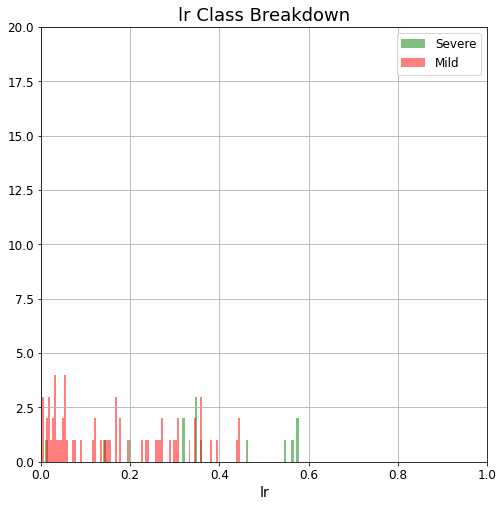

In [94]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='lr', 
                          plot_title='lr Class Breakdown', bins=100)

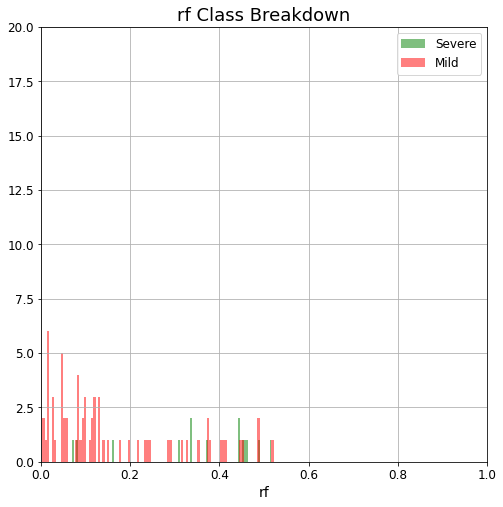

In [95]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='rf', 
                          plot_title='rf Class Breakdown', bins=100)

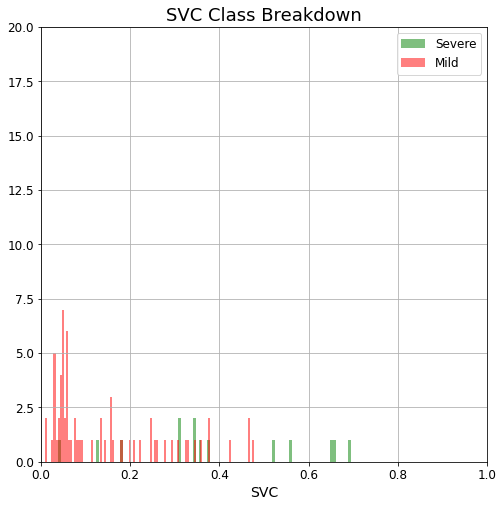

In [96]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='SVC', 
                          plot_title='SVC Class Breakdown', bins=100)

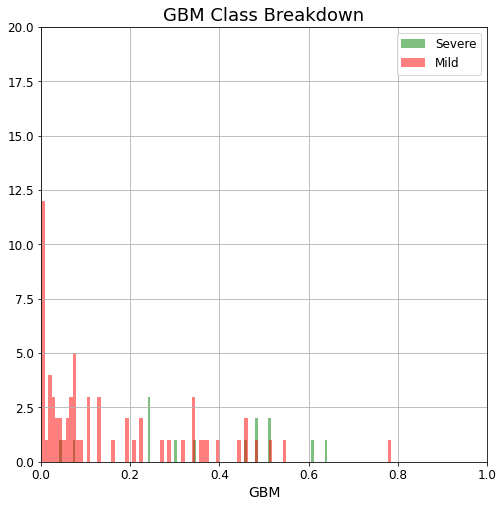

In [97]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='GBM', 
                          plot_title='GBM Class Breakdown', bins=100)

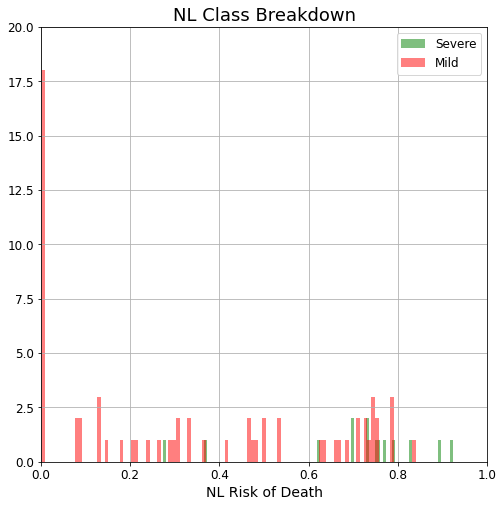

In [98]:
plot_class_breakdown_hist(data_test, 'NL_pred_proba', var_name='NL Risk of Death', 
                          plot_title='NL Class Breakdown', bins=100)

In [99]:
data_test

severity  lr_pred_proba  rf_pred_proba  svc_pred_proba  gbm_pred_proba  \
0          0       0.295814       0.317929        0.281243        0.287239   
1          0       0.169919       0.128944        0.087616        0.021902   
2          0       0.033886       0.014008        0.050424        0.002427   
3          1       0.347321       0.445143        0.343668        0.511871   
4          0       0.078457       0.120880        0.080967        0.131271   
..       ...            ...            ...             ...             ...   
75         0       0.018815       0.031751        0.031789        0.005063   
76         0       0.300571       0.285506        0.197873        0.320490   
77         0       0.031870       0.024220        0.050642        0.021015   
78         0       0.057562       0.028806        0.029761        0.001948   
79         0       0.088912       0.048687        0.023967        0.022439   

    NL_pred_proba  
0        0.672384  
1        0.299309  
2        0.000151  
3        0.729247  
4        0.472125  
..            ...  
75       0.000000  
76       0.532874  
77       0.129173  
78       0.000000  
79       0.082962  

[80 rows x 6 columns]

In [100]:
data_all=pred_proba(train_Features, train_Label, X, Y, model)

In [101]:
data_all

severity  lr_pred_proba  rf_pred_proba  svc_pred_proba  gbm_pred_proba  \
0           0       0.155124       0.142051        0.142427        0.170471   
1           0       0.402667       0.469776        0.410258        0.486307   
2           0       0.011906       0.082714        0.039529        0.072463   
3           0       0.017844       0.056504        0.035895        0.007188   
4           0       0.333082       0.338786        0.341199        0.300465   
..        ...            ...            ...             ...             ...   
793         0       0.018245       0.015546        0.010433        0.000631   
794         0       0.060681       0.088447        0.049528        0.049817   
795         0       0.002898       0.003343        0.030323        0.003204   
796         0       0.079883       0.081200        0.058812        0.044675   
797         0       0.019854       0.034807        0.058397        0.001300   

     NL_pred_proba  
0         0.333802  
1         0.772683  
2         0.420058  
3         0.000000  
4         0.750706  
..             ...  
793       0.000000  
794       0.000000  
795       0.000000  
796       0.000000  
797       0.000007  

[798 rows x 6 columns]

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
df_test2=test_df.reset_index(drop=True)
df_test2['NL_pred_proba']=data_test['NL_pred_proba']

plot_test_data=df_test2.loc[(df_test2['Severity']==1)&(df_test2['NL_pred_proba']<0.5)]

In [104]:
df_test2.shape

(80, 7)

In [105]:
plot_test_data

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
25         1    0   56    1    0    0       0.367686
45         1    0   63    1    0    0       0.274161

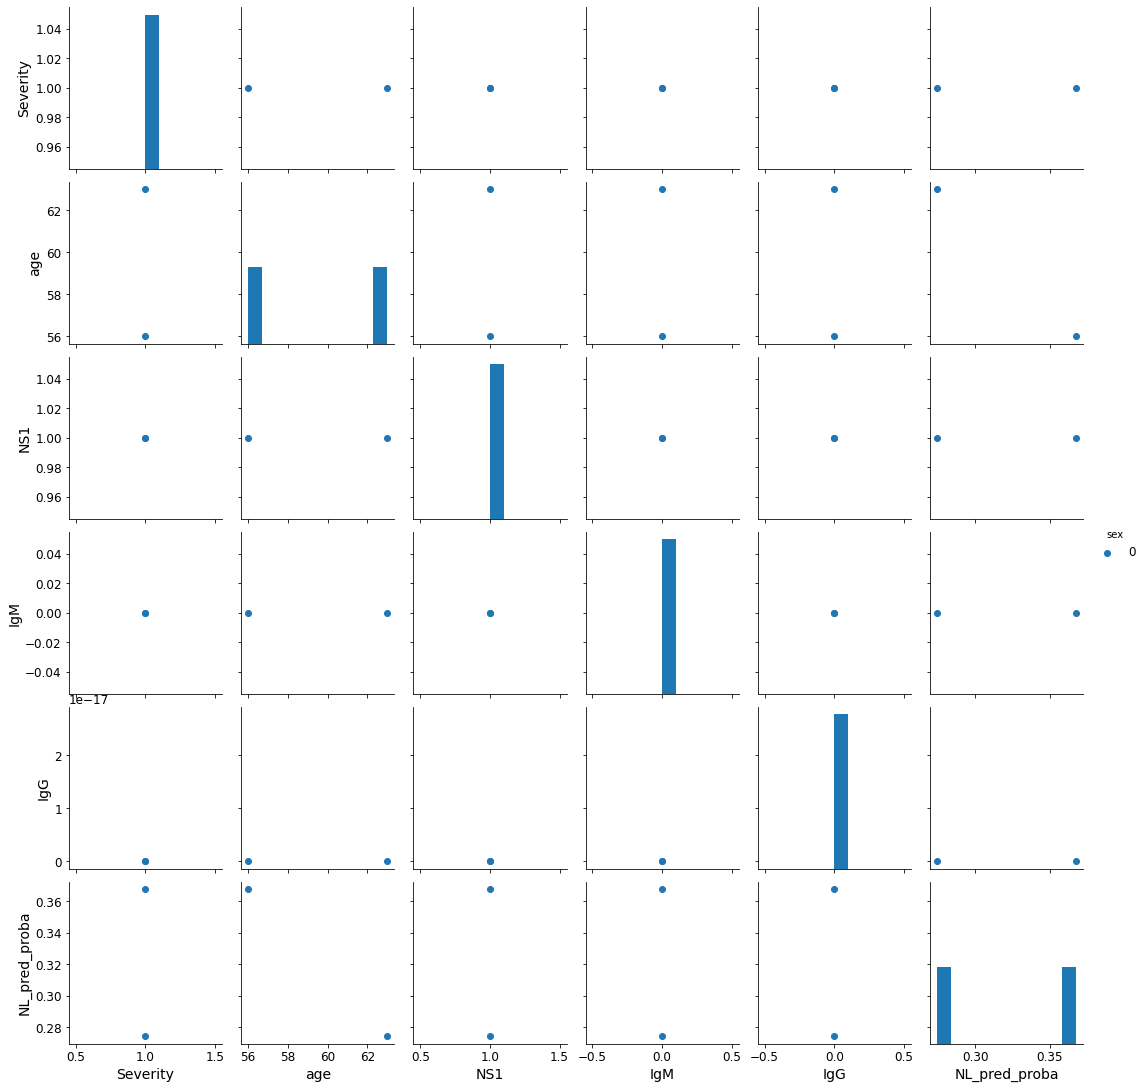

In [106]:
g_test = sns.PairGrid(plot_test_data, hue='sex')
g_test.map_diag(plt.hist)
g_test.map_offdiag(plt.scatter)
g_test.add_legend()

In [107]:
df_test3=test_df.reset_index(drop=True)
df_test3['NL_pred_proba']=data_test['NL_pred_proba']

plot_test_data2=df_test3.loc[(df_test3['Severity']==0)&(df_test3['NL_pred_proba']>0.5)]

In [108]:
plot_test_data2

Severity  sex  age  NS1  IgM  IgG  NL_pred_proba
0          0    0   72    1    0    0       0.672384
5          0    0   68    1    1    1       0.503807
7          0    0   83    1    0    1       0.739676
9          0    0   53    1    1    1       0.501668
12         0    0   83    1    0    0       0.787527
14         0    1   67    1    0    0       0.741329
18         0    1   77    1    0    1       0.659136
22         0    1   65    1    0    0       0.730033
24         0    1   75    1    0    0       0.754933
26         0    0   77    1    0    0       0.745331
28         0    1   63    1    1    1       0.840692
33         0    0   76    1    0    0       0.729247
38         0    1    1    1    0    0       0.782668
39         0    0   70    1    0    0       0.627333
41         0    1   61    1    0    0       0.631827
42         0    0   83    1    0    0       0.787527
43         0    0   80    1    0    1       0.713647
52         0    0   73    1    0    0       0.685342
53         0    0   73    0    0    0       0.531133
57         0    0   75    1    0    0       0.712464
66         0    1   68    1    0    0       0.743606
70         0    1   75    1    0    0       0.754933
76         0    1   71    1    0    1       0.532874

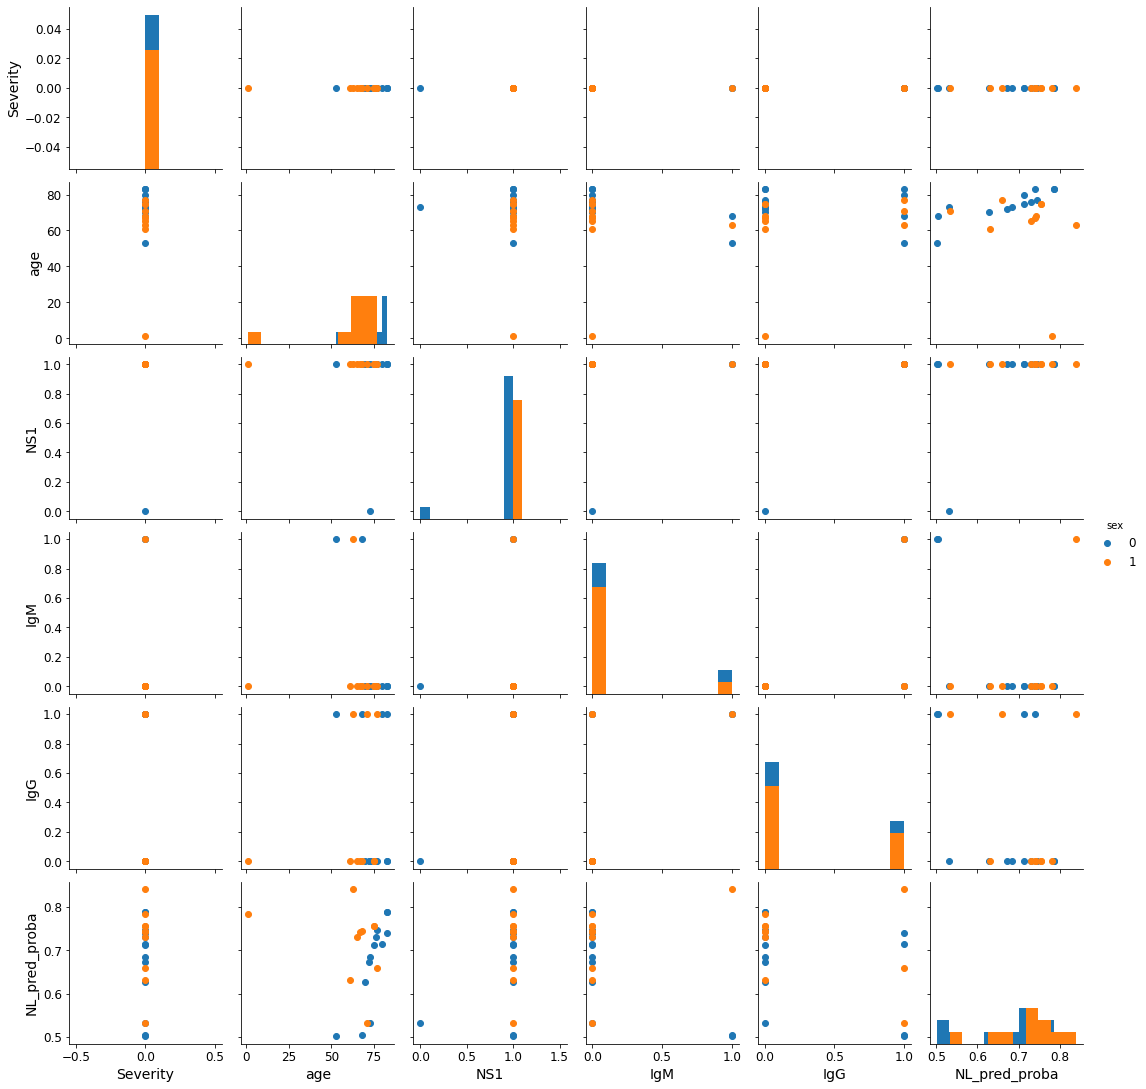

In [109]:
g_test = sns.PairGrid(plot_test_data2, hue='sex')
g_test.map_diag(plt.hist)
g_test.map_offdiag(plt.scatter)
g_test.add_legend()

In [110]:
df_all2=df.reset_index(drop=True)
df_all2['NL_pred_proba']=data_all['NL_pred_proba']

plot_all_data=df_all2.loc[(df_all2['Severity']==1)&(df_all2['NL_pred_proba']<0.5)]

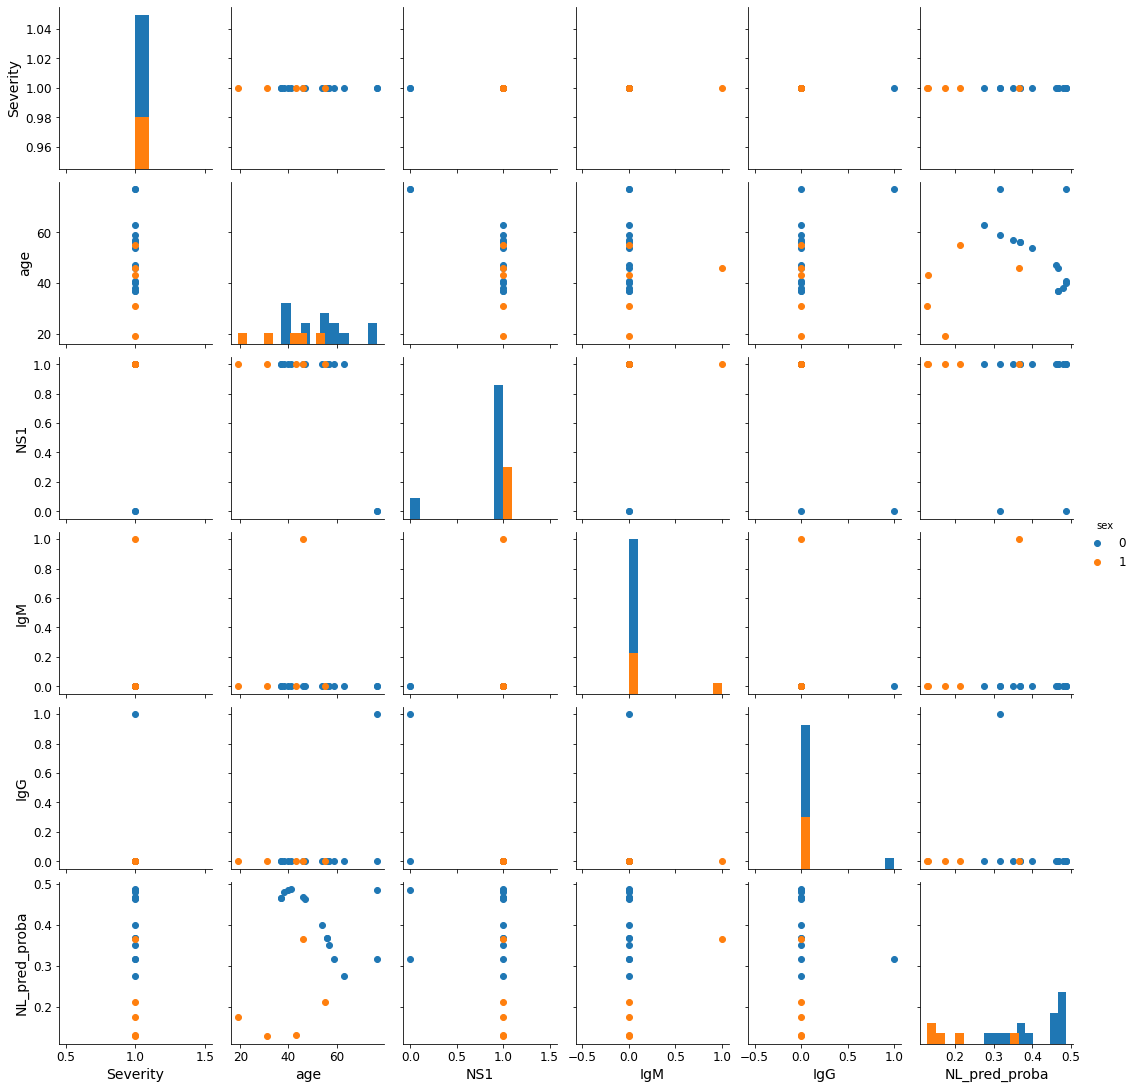

In [111]:
g = sns.PairGrid(plot_all_data, hue='sex')
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [112]:
def plot_class_breakdown_hist2(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.severity == 1].hist(alpha=.5, label='Severe', color = "green", **histkwargs)
    df[var][df.severity == 0].hist(alpha=.5, label='Mild', color = "red", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.xlim(xmax=1, xmin=0)   
    plt.ylim(ymax=100, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

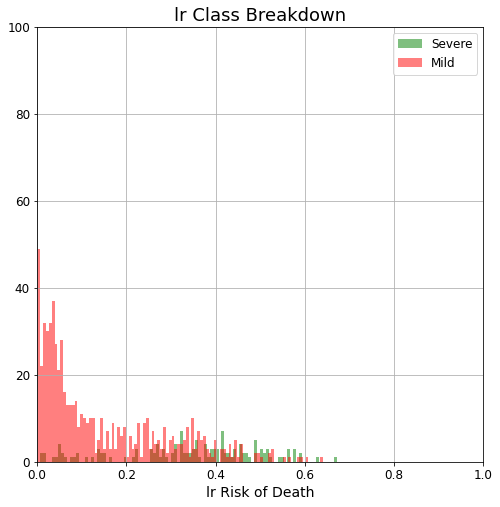

In [113]:
plot_class_breakdown_hist2(data_all, 'lr_pred_proba', var_name='lr Risk of Death', 
                          plot_title='lr Class Breakdown', bins=100)

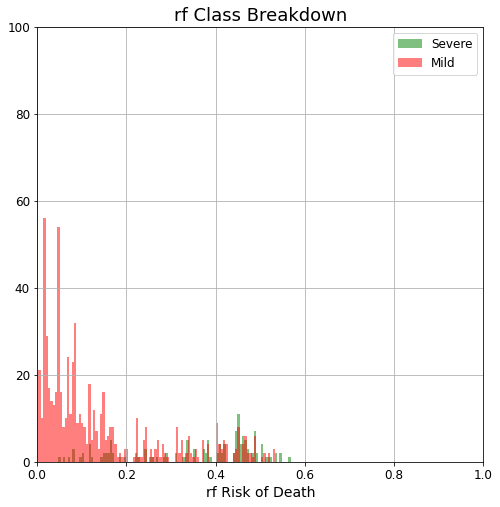

In [114]:
plot_class_breakdown_hist2(data_all, 'rf_pred_proba', var_name='rf Risk of Death', 
                          plot_title='rf Class Breakdown', bins=100)

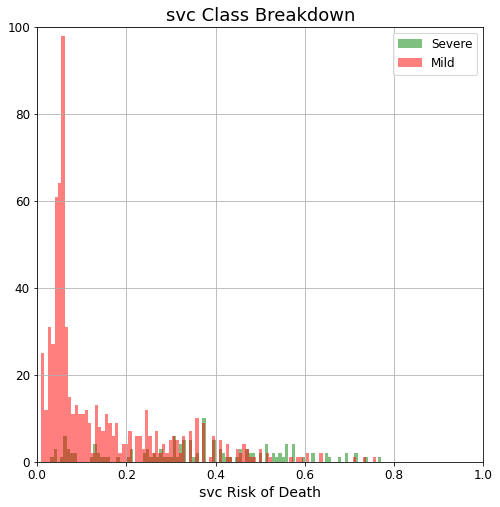

In [115]:
plot_class_breakdown_hist2(data_all, 'svc_pred_proba', var_name='svc Risk of Death', 
                          plot_title='svc Class Breakdown', bins=100)

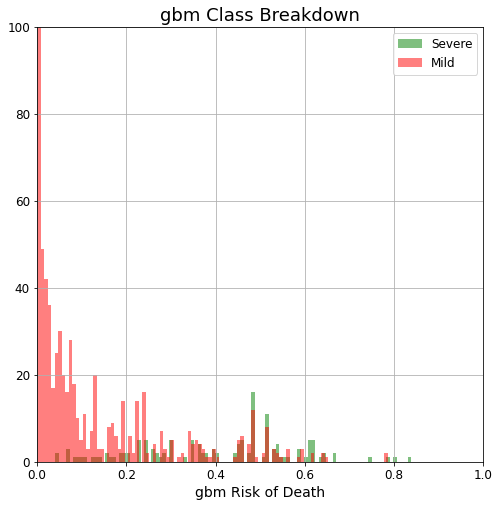

In [116]:
plot_class_breakdown_hist2(data_all, 'gbm_pred_proba', var_name='gbm Risk of Death', 
                          plot_title='gbm Class Breakdown', bins=100)

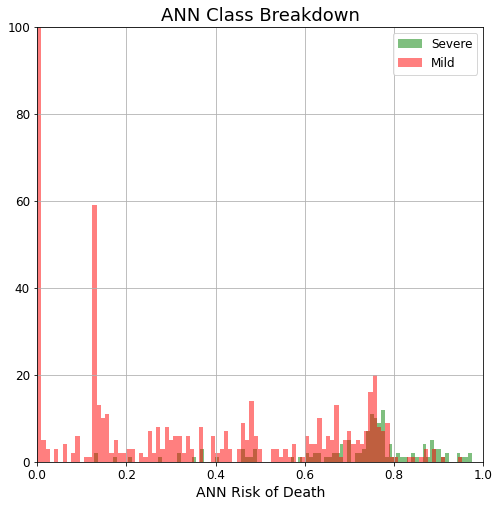

In [120]:
plot_class_breakdown_hist2(data_all, 'NL_pred_proba', var_name='ANN Risk of Death', 
                          plot_title='ANN Class Breakdown', bins=100)